# Spanish postal code areas content-based recommendation system

## Index

1. [Introduction](#introduction)
1. [Data to be used](#data-used)
1. [Methodology](#methodology)
    1. [Notebook preparation](#notebook-preparation)
    1. [Data obtention](#data-obtention)
        1. [Cities data](#data-obtention-cities)
        1. [Postal codes data](#data-obtention-postalcode)
        1. [Venues data](#data-obtention-venues)
    1. [Data processing](#data-processing)
    1. [Build recommendator algorithm](#build-recommendator-algorithm)
        1. [Test and tune recommendator algorithm](#test-recommendator-algorithm)
    1. [Build visualizer](#build-visualizer)
    1. [Build application](#build-application)
1. [Results](#results)
    1. [Results for similarity criterium](#results-similarity)
    1. [Results for density criterium](#results-density)
1. [Discussion](#discussion)
1. [Conclusions](#conclusions)

<a id="introduction"></a>
## 1. Introduction

When people need to move in to another city, choosing the right area to live in the new city, without knowing the new city, could be a challenge. There are many variables in choosing the right area to live, and the knowledge about the new city may be limited, which can result in choosing an area which will not be the suitable for a person, deriving in a wide range of  problems, from logistics problems like increases in travelling times to the different places and venues visited in the day-to-day to psychological problems derived from unhappiness with the place chosen.

Although each country, or even each city in the same country have different ways to organize the neighborhoods and areas of a city, there is one which can be considered universal, which is the postal code area.

My idea for this project is to use clustering a set of data science techniques for designing a content-based recommendation system for choosing the postal code area to live in a new city which will fit best with the user based on information provided by him.

The user will be able to choose wether he wants a recommendation based on the similarity with the neighborhood or the density of venues. If the similarity approach is taken, the following data will be required to the user:
- The postal code where he is living right now.
- The city where he is planning to move in.
- The type of amenities he is interested in.

If the density approach is taken, the following data will be required to the user:
- The city where he is planning to move in.
- The type of amenities he is interested in.

For the first approach, the idea will be set in the 15 most populous cities of Spain, in order to make a first prototype with enough complexity. 

The target users for the recommendator systems will have the following  characteristics:

- People living in Spain or thinking about moving in to Spain.
- People thinking about moving in to another home, in the same city or in another Spanish city.
- People which considers the amenities of the area as an important feature for choosing a home.

<a id="data-used"></a>
## 2. Data to be used

For developing the idea proposed, both data about postal code areas of Spain and the venues located at each of the postal code areas is required.

For data regarding spanish postal codes, the information provided by the Spanish Mail Delivery Office will be used. These information provides data about each postal code of Spain, the city or town it belongs to and its geographical boundaries. The information to be requested to this data source is a list of postal codes, each of one with the following fields:

- ID of the postal code area.
- City where the postal code area is located.
- Geographical boundaries of the postal code area in the form of GeoJSON file.

Thanks to Inigo Flores, these information is available in CSV and GeoJSON formats at https://github.com/inigoflores/ds-codigos-postales.

As commented in the introdution, the Spanish Mail Delivery Office dataset will be filtered for getting the postal codes corresponding to the 15 most populous cities of Spain. These 15 cities will be configured by using a hand made JSON file.

For data regarding venues located at each of the postal code areas of Spain, Foursquare database will be used. Foursquare provides a REST API for connecting with Foursquare database, providing the required methods for getting basic information about venues located in an area. The information will be requested to Foursquare API for each postal code area of the ones selected previously, getting latitude, longitude and area radius from the geographical boundaries of each ofthe postal code areas. For each postal code area the following information will be requested:

- Number of venues in the area.
- List of the most relevant venues of the area, with the following info for each of them:
    - Venue name.
    - Venue location (latitude and longitude).
    - Venue category (both primary, secondary and final category).

<a id="methodology"></a>
## 3. Methodology

In this section the methodology for creating the recommendation system will be shown.

<a id="notebook-preparation"></a>
### 3.A. Notebook preparation

The first step is to download the libraries required which are not included by default:

In [705]:
 # Download library for map rendering
!pip install folium
 # Download library for getting coordinates
!pip install geocoder
# Download library to convert an address into latitude and longitude values
!pip install geopy
# Download library for decoding strings
!pip install Unidecode 
# Modules for processing GeoJSON areas
!pip install area

And now make the imports which will be required in the project:

In [786]:
#import standard libraries
import re
import warnings
import math

# import string decoding library
import unidecode

# import pandas and numpy libraries
import pandas as pd
import numpy as np

# library to handle requests
import requests 

# Library for get latitude and longitude of a position
import geocoder

# module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# import different modules for machine learning recommendation and/or clustering
from scipy.spatial import distance_matrix 
from scipy.cluster import hierarchy 

# Import modules for creating linear color maps
from branca.colormap import linear
    
# tranforming json file into a pandas dataframe library
from pandas import json_normalize

# Module for map plotting
import folium
from folium.plugins import MarkerCluster

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Modules for user interface
import ipywidgets as widgets

# Modules for getting info from REST APIs
import json
import urllib
import requests

#Modules for plots
import matplotlib.pyplot as plt

# Modules for mathematical operations
from math import sin, cos, sqrt, atan2, radians
import random

# Modules for correlation
from scipy.stats import pearsonr

# Modules for processing GeoJSON areas
from area import area

Later we define a set of functions for getting the location of both a postal code and city, so as the distance between coordinates:

In [787]:
def get_latlong_postalcode(postal_code, city, region):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        try:
            g = geocoder.arcgis('{}, {}, {}, Spain'.format(postal_code, city, region))
            lat_lng_coords = g.latlng
        except GeocoderTimedOut as e:
            lat_lng_coords = None
    return lat_lng_coords

def get_latlong_city(city, region):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        try:
            g = geocoder.arcgis('{}, {}, Spain'.format(city, region))
            lat_lng_coords = g.latlng
        except GeocoderTimedOut as e:
            lat_lng_coords = None
    return lat_lng_coords

def get_distance_between_coordinates(coordinate1, coordinate2):
    R = 6373000
    lat1 = radians(coordinate1[1])
    lon1 = radians(coordinate1[0])
    lat2 = radians(coordinate2[1])
    lon2 = radians(coordinate2[0])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(coordinate1[1]) * cos(coordinate2[1]) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = int(R * c)
    return distance

<a id="data-obtention"></a>
### 3.B Data obtention

Now it's the time for getting the data required for creating the recommendation system. 

<a id="data-obtention-cities"></a>
#### 3.B.a. Cities data

The first step will be to define a dataframe with the cities which will be included inthe recommendation system. The 15 most populous cities of Spain have been selected, defining city, region, ID of the city (got from an observation of the postal code dataset) and name of the file with the GeoJSON information about the postal codes of each city.

For each city, the location will be got using Arcgis geocoder library.

In [708]:
cities = [
    {
        "city": "Madrid",
        "region": "Madrid",
        "id": "28079",
        "geojson_file": "madrid.geojson"
    },
    {
        "city": "Barcelona",
        "region": "Cataluña",
        "id": "08019",
        "geojson_file": "barcelona.geojson"
    },
    {
        "city": "Valencia",
        "region": "Comunidad Valenciana",
        "id": "46250",
        "geojson_file": "valencia.geojson"
    },
    {
        "city": "Sevilla",
        "region": "Andalucia",
        "id": "41091",
        "geojson_file": "sevilla.geojson"
    },
    {
        "city": "Zaragoza",
        "region": "Aragón",
        "id": "50297",
        "geojson_file": "zaragoza.geojson"
    },
    {
        "city": "Málaga",
        "region": "Andalucia",
        "id": "29067",
        "geojson_file": "malaga.geojson"
    },
    {
        "city": "Murcia",
        "region": "Murcia",
        "id": "30030",
        "geojson_file": "murcia.geojson"
    },
    {
        "city": "Palma De Mallorca",
        "region": "Baleares",
        "id": "07040",
        "geojson_file": "mallorca.geojson"
    },
    {
        "city": "Las Palmas De Gran Canaria",
        "region": "Canarias",
        "id": "35016",
        "geojson_file": "palmascanarias.geojson"
    },
    {
        "city": "Bilbao",
        "region": "País Vasco",
        "id": "48020",
        "geojson_file": "bilbao.geojson"
    },
    {
        "city": "Alicante",
        "region": "Comunidad Valenciana",
        "id": "03014",
        "geojson_file": "alicante.geojson"
    },
    {
        "city": "Córdoba",
        "region": "Andalucía",
        "id": "14021",
        "geojson_file": "cordoba.geojson"
    },
    {
        "city": "Valladolid",
        "region": "Castilla - Leon",
        "id": "47186",
        "geojson_file": "valladolid.geojson"
    },
    {
        "city": "Vigo",
        "region": "Galicia",
        "id": "36057",
        "geojson_file": "vigo.geojson"
    },
    {
        "city": "Gijón",
        "region": "Asturias",
        "id": "33024",
        "geojson_file": "gijon.geojson"
    },
]
for city in cities:
    latitude, longitude = get_latlong_city(city["city"], city["region"])
    city["latitude"] = latitude
    city["longitude"] = longitude

df_spain_cities = pd.DataFrame([item for item in cities])

Let's check the dataset has been created suitably.

In [709]:
df_spain_cities

,city,region,id,geojson_file,latitude,longitude
0,Madrid,Madrid,28079,madrid.geojson,40.419550,-3.691960
1,Barcelona,Cataluña,08019,barcelona.geojson,41.388040,2.170010
2,Valencia,Comunidad Valenciana,46250,valencia.geojson,39.468940,-0.376860
3,Sevilla,Andalucia,41091,sevilla.geojson,37.387880,-6.001960
4,Zaragoza,Aragón,50297,zaragoza.geojson,41.651830,-0.881140
5,Málaga,Andalucia,29067,malaga.geojson,36.718470,-4.419650
6,Murcia,Murcia,30030,murcia.geojson,37.983080,-1.131380
7,Palma De Mallorca,Baleares,07040,mallorca.geojson,39.571480,2.646940
8,Las Palmas De Gran Canaria,Canarias,35016,palmascanarias.geojson,28.139449,-15.428506
9,Bilbao,País Vasco,48020,bilbao.geojson,43.268900,-2.945290


And show a folium map of spain in order to check the locations are correct.

In [710]:
# create Spain map
latitude = df_spain_cities[df_spain_cities["city"] == "Madrid"]["latitude"]
longitude = df_spain_cities[df_spain_cities["city"] == "Madrid"]["longitude"]
map_spain = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to the map
markers_colors = []
for lat, lon, city in zip(df_spain_cities['latitude'], 
                                 df_spain_cities['longitude'], 
                                 df_spain_cities['city']):
    label = folium.Popup(city, parse_html=True)
    folium.Marker(
        [lat, lon],
        popup=label).add_to(map_spain)
       
map_spain

The created dataset will be stored in CSV format in order to load it directly in the future.

In [711]:
df_spain_cities.to_csv('processed_data/df_spain_cities.csv')

<a id="data-obtention-postalcodes"></a>
#### 3.B.b. Postal codes data

The next step is to get the data of the postal codes, that is the name, city and region belonging to, latitude and longitude location and influence radius. This can be got with the following code:

In [712]:
# Create a list of postal codes, empty for now,
spain_postcodes = []
# Read the postal codes of Spain
df_spain_postcodes_raw = pd.read_csv("input_data/codigos_postales_municipios.csv")
# For each city in the list chosen
for _, city in df_spain_cities.iterrows():
    print("Processing GEOJSON of " +  city['city'] + " ...                                                                  \r", end="")
    # Get list of postal codes located in the city
    postal_codes_array = df_spain_postcodes_raw[df_spain_postcodes_raw["municipio_id"] == int(city['id'])]["codigo_postal"].unique()
    # Open the GeoJSON file
    geojson_file = "input_data/geojson/" + city["geojson_file"]
    with open(geojson_file, "r") as f:
        geojson = json.load(f)
    # Filter all postal codes from the GeoJSON file areas not corresponding neither to the city nor to the postal codes expected.
    geojson["features"] = [x for x in geojson["features"] if ((int(x['properties']['COD_POSTAL']) in postal_codes_array) and (x['properties']['CODIGO_INE'] == int(city["id"])))]  
    # Save the filtered GeoJSON file
    new_geojson_file = "processed_data/geojson/" + city["geojson_file"]
    with open(new_geojson_file, "w") as f:
        json.dump(geojson, f, ensure_ascii = True)
    # for each postal code defined in the GeoJSON
    for index, postal_code_info in enumerate(geojson["features"]):
        print("Processing postal code " + str(index + 1) + "/" + str(len(geojson["features"])) + " of " + city['city'] + " ...                                          \r", end="")
        postal_code = postal_code_info['properties']['COD_POSTAL']
        # Get a list of all the points composing the GeoJSON area defined for the postal code
        polygon_points = np.array(postal_code_info['geometry']['coordinates'])
        number_points = 1
        if type(polygon_points[0]) == list:
            polygon_points_new = None
            for polygon_point_list in polygon_points:
                polygon_point_list = np.array(polygon_point_list)
                if polygon_points_new is None:
                    polygon_points_new = polygon_point_list
                else:
                    np.append(polygon_points_new, polygon_point_list)
            polygon_points = polygon_points_new
        elif type(polygon_points[0][0]) == list:
            polygon_points_new = np.array([])
            for polygon_point_list in polygon_points:
                polygon_point_list = np.array(polygon_point_list)
                if polygon_points_new is None:
                    polygon_points_new = polygon_point_list
                else:
                    np.append(polygon_points_new, polygon_point_list)
            polygon_points = polygon_points_new
        for dimension in polygon_points.shape:
            number_points *= dimension
        number_points = number_points//2
        polygon_points.shape = (number_points, 2)
        # Get the mean of all these location points, serving as the location center of the area
        center = np.mean(polygon_points, axis=0)
        # Work out the max distance between the center and any of the points, serving as influence radius of the area
        radius = 0
        for point in polygon_points:
            distance = get_distance_between_coordinates(point, center)
            if distance > radius:
                radius = distance
        # Work out area of postal code
        area_postal_code = area(postal_code_info['geometry'])/1000000
        # Enter into the list of postal codes the info about the area being processed
        spain_postcodes.extend([(
            str(postal_code), 
            center[1], 
            center[0], 
            radius,
            area_postal_code,
            city['city'], 
            city['region'])])
          
# Convert the postal code list into a pandas dataframe
df_spain_postcodes = pd.DataFrame([item for item in spain_postcodes]).reset_index(drop=True)
df_spain_postcodes.columns = [
              'postal_code', 
              'postal_code_latitude', 
              'postal_code_longitude', 
              'postal_code_influence_radius', 
              'postal_code_area', 
              'city', 
              'region']
print("Done!                                                                                                                                                                                      ")

Done!                                                                                                                                                                                      


Let's check the dataframe has been generated correctly:

In [713]:
df_spain_postcodes.head()

,postal_code,postal_code_latitude,postal_code_longitude,postal_code_influence_radius,postal_code_area,city,region
0,28008,40.428637,-3.721715,1852,2.666933,Madrid,Madrid
1,28053,40.382848,-3.666193,3238,7.886590,Madrid,Madrid
2,28041,40.367535,-3.699625,2523,8.322672,Madrid,Madrid
3,28036,40.464037,-3.682459,2394,2.584964,Madrid,Madrid
4,28033,40.471593,-3.648874,2961,6.065038,Madrid,Madrid


In [714]:
df_spain_postcodes.shape

(504, 7)

It can be seen that there are repeated postal codes, and all repeated postal codes are of extremely small area except for one. 

The postal code dataframe will be filtered in order to remove all those insignificant repeated postal codes:

In [715]:
df_spain_postcodes = df_spain_postcodes.groupby('postal_code').apply(lambda x: x.loc[x.postal_code_area.idxmax()]).reset_index(drop=True)
df_spain_postcodes = df_spain_postcodes.dropna().reset_index(drop=True)

In [716]:
df_spain_postcodes.shape

(435, 7)

The created dataset will be stored in CSV format in order to load it directly in the future.

In [717]:
df_spain_postcodes.to_csv('processed_data/df_spain_postcodes.csv')

Let's check the creation of the postal codes dataset by showing the data into a Spain map.

In [718]:
# create Spain map
latitude = cities[0]["latitude"]
longitude = cities[0]["longitude"]
map_spain = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to the map
markers_colors = []
for lat, lon, postal_code in zip(df_spain_postcodes['postal_code_latitude'], 
                                 df_spain_postcodes['postal_code_longitude'], 
                                 df_spain_postcodes['postal_code']):
    label = folium.Popup(str(postal_code), parse_html=True)
    folium.Marker(
        [lat, lon],
        popup=label).add_to(map_spain)
       
map_spain

With the info obtained from the postal codes, the influence radius of each city will be worked out, updated in the cities dataset and saved:

In [719]:
df_spain_cities["influence_radius"] = 0
for index, city in df_spain_cities.iterrows():
    city_radius = 0
    city_center_coordinate = [city["latitude"], city["longitude"]]
    df_postcodes_city = df_spain_postcodes[df_spain_postcodes["city"] == city["city"]]
    for _, postcode in df_postcodes_city.iterrows():
        postal_code_coordinate = [postcode["postal_code_latitude"], postcode["postal_code_longitude"]]
        distance = get_distance_between_coordinates(city_center_coordinate, postal_code_coordinate) + postcode["postal_code_influence_radius"]
        if distance > city_radius:
            city_radius = distance
    df_spain_cities.loc[index, "influence_radius"] = city_radius

In [720]:
df_spain_cities.head()

,city,region,id,geojson_file,latitude,longitude,influence_radius
0,Madrid,Madrid,28079,madrid.geojson,40.41955,-3.69196,33645
1,Barcelona,Cataluña,08019,barcelona.geojson,41.38804,2.17001,14132
2,Valencia,Comunidad Valenciana,46250,valencia.geojson,39.46894,-0.37686,22409
3,Sevilla,Andalucia,41091,sevilla.geojson,37.38788,-6.00196,20747
4,Zaragoza,Aragón,50297,zaragoza.geojson,41.65183,-0.88114,35894


In [721]:
df_spain_cities.to_csv('processed_data/df_spain_cities.csv')

<a id="data-obtention-postalcodes"></a>
#### 3.B.c. Venues data

The last dataset to get is the list of most relevant venues of each postal code to be analized. In order to do so, Foursquare places API will be used.

First the credentials for the Foursquare API will be set.

In [722]:
CLIENT_ID = '13NUHFZPOD2RG5D5KTBOKQD3N5OESQHFTL1VZU0YYNBFQT1S' # your Foursquare ID
CLIENT_SECRET = 'NVOGX55INF4QMOVXCHS3PLHTJ45YZT202KKEZBJAWZRCEEVD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # A default Foursquare API limit value
OFFSET_LIMIT = 5000 # Acting with limit, setting max venues searched to 5000
RADIUS = 2000 # Equivalent to 30 minute walking

def getFoursquareClientCredentials():
    return CLIENT_ID, CLIENT_SECRET

client_id, client_secret = getFoursquareClientCredentials()
print('Your credentails:')
print('CLIENT_ID: ' + client_id)
print('CLIENT_SECRET:' + client_secret)

Your credentails:
CLIENT_ID: 13NUHFZPOD2RG5D5KTBOKQD3N5OESQHFTL1VZU0YYNBFQT1S
CLIENT_SECRET:NVOGX55INF4QMOVXCHS3PLHTJ45YZT202KKEZBJAWZRCEEVD


Now the list of categories availables will be got.

There is three possible levels of categories, and here are defined the functions for getting both primary and secondary categories from a final category.

In [723]:
client_id, client_secret = getFoursquareClientCredentials()
urlCategories = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    client_id, 
    client_secret, 
    VERSION)

# make the GET request
categories_json = requests.get(urlCategories).json()["response"]

def checkPrimaryCategoryByLevel(categoriesList, categoriesDict, primaryCategory):
    for category in categoriesList:
        category_name = re.sub(r'\([^)]*\)', '', category["name"])
        categoriesDict[category_name] = primaryCategory
        if (len(category["categories"]) > 0):
            categoriesDict = checkPrimaryCategoryByLevel(category["categories"], categoriesDict, primaryCategory)
    return categoriesDict

# This is the code for 1st level categories
primaryCategoriesDict = {}
for category in categories_json["categories"]:
    category_name = re.sub(r'\([^)]*\)', '', category["name"])
    primaryCategoriesDict[category_name] = category_name
    if (len(category["categories"]) > 0):
        primaryCategoriesDict = checkPrimaryCategoryByLevel(category["categories"], primaryCategoriesDict, category_name)

# This is the code for 2nd level categories
secondCategoriesDict = {}
for category in categories_json["categories"]:
    category_name = re.sub(r'\([^)]*\)', '', category["name"])
    secondCategoriesDict[category_name] = category_name
    if (len(category["categories"]) > 0):
        for second_category in category["categories"]:
            second_category_name = re.sub(r'\([^)]*\)', '', second_category["name"])
            secondCategoriesDict[second_category_name] = second_category_name
            if (len(second_category["categories"]) > 0):
                secondCategoriesDict = checkPrimaryCategoryByLevel(second_category["categories"], secondCategoriesDict, second_category_name)
                
def translateVenueToPrimaryCategory(category):
    return primaryCategoriesDict[category]

def translateVenueToSecondaryCategory(category):
    return secondCategoriesDict[category]

Finally a function will be defined for getting from the info about a postal codes a list of all the venues of the area, using paginated Foursquare API call to the explore endpoint. As input variables to the function, they will be used the longitude and latitude location and the influence radius for defining the searching area, so as the city, region and postal code ID. As a result, it will be obtained the total number of venues in the area and a list of venues. For each venue, it will be provided the name of the venue, it's location, the categories corresponding to the venue and address info.

Another function will be defined for getting the combined list of all the venues of all postal codes inside a postal code dataset, getting a dataframe will all venues info explained previously and a dataframe with the total number of venues per postal code as a result.

In [724]:
def getNearbyVenuesForArea(postal_code, latitude, longitude, radius, city, region): 
    venues_list=[]
    offset=0
    last_results_count = LIMIT
    total_results = 0
    while (last_results_count == LIMIT) and (offset <= OFFSET_LIMIT):
        # create the API request URL
        client_id, client_secret = getFoursquareClientCredentials()
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
            client_id, 
            client_secret, 
            VERSION, 
            latitude, 
            longitude, 
            radius,
            LIMIT,
            offset)
        # make the GET request
        response = requests.get(url).json()
        if not bool(response["response"]):
            break
        if total_results == 0:
            total_results = response["response"]["totalResults"]
        results = response["response"]['groups'][0]['items']
        last_results_count = len(results)
        venues_list.extend([(
            v['venue']['id'], 
            v['venue']['name'], 
            int(v['venue']['location']['postalCode']) if (('postalCode' in v['venue']['location']) and (v['venue']['location']['postalCode'].isnumeric())) else postal_code,  
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            re.sub(r'\([^)]*\)', '', v['venue']['categories'][0]['name']),
            translateVenueToPrimaryCategory(re.sub(r'\([^)]*\)', '', v['venue']['categories'][0]['name'])), 
            translateVenueToSecondaryCategory(re.sub(r'\([^)]*\)', '', v['venue']['categories'][0]['name'])),
            postal_code, 
            city) for v in results])
        offset += LIMIT
    return venues_list, total_results
    
def getNearbyVenuesForDataset(dataset): 
    postcode_total_venues_list=[]
    venues_list=[]
    size = dataset.shape[0]
    for index, postcode in dataset.iterrows():
        print("Processing area " + str(index + 1) + "/" + str(size) + ": " + str(postcode['postal_code']) + ", " + postcode['city'] + "                                          \r", end="")
        venues, total_venues = getNearbyVenuesForArea(postcode['postal_code'], 
                                          postcode['postal_code_latitude'], 
                                          postcode['postal_code_longitude'], 
                                          postcode['postal_code_influence_radius'], 
                                          postcode['city'], 
                                          postcode['region'])
        postcode_total_venues_list.append((
            postcode['postal_code'], 
            total_venues))
        venues_list.extend(venues)
    df_venues = pd.DataFrame([item for item in venues_list])
    df_venues.columns = [
                  'id', 
                  'venue',  
                  'postal_code',
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category',
                  'venue_category_primary',  
                  'venue_category_secondary', 
                  'postal_code_search_area',
                  'city']
    df_postcodes_total_venues = pd.DataFrame([item for item in postcode_total_venues_list])
    df_postcodes_total_venues.columns = [
                  'postal_code', 
                  'total_venues']
    print("Done                                                                                               ")
    return df_venues, df_postcodes_total_venues

And we use these functions for getting the venues of all postal codes to be considered and the number of venues at each of them.

In [725]:
df_spain_venues, df_spain_postcodes_total_venues = getNearbyVenuesForDataset(df_spain_postcodes)

Done                                                                                                


We check both of them. First the total number of venues per postal code.

In [789]:
df_spain_postcodes_total_venues.head()

,postal_code,total_venues
0,3001,133
1,3002,120
2,3003,85
3,3004,88
4,3005,129


In [790]:
df_spain_postcodes_total_venues.shape

(435, 2)

And now the info about every venue at each of the postal codes.

In [794]:
df_spain_venues.head()

,id,venue,postal_code,venue_latitude,venue_longitude,venue_category,venue_category_primary,venue_category_secondary,postal_code_search_area,city
0,55806cf1498e4fafe583f700,Bodhigreen,3001,38.342650,-0.486249,Vegetarian / Vegan Restaurant,Food,Vegetarian / Vegan Restaurant,3001,Alicante
1,5a3986fa8ad62e34d744fc32,Tapas Bar Manero,3001,38.343980,-0.483836,Tapas Restaurant,Food,Spanish Restaurant,3001,Alicante
2,56a6a85d498e9123f041ff48,Restaurante Terre,3003,38.343373,-0.483370,Spanish Restaurant,Food,Spanish Restaurant,3001,Alicante
3,4bc46ebe461576b0f2dc7f32,El Portal Taberna & Wines,3001,38.344123,-0.483551,Wine Bar,Nightlife Spot,Bar,3001,Alicante
4,4dc1aaa252b1877d85b97fd9,La Barra de César Anca,3001,38.342905,-0.484981,Tapas Restaurant,Food,Spanish Restaurant,3001,Alicante


In [795]:
df_spain_venues.shape

(42673, 10)

And we check that the number of venues obtained is the same as the expected one by th esum of total venues of each postal code:

In [796]:
df_spain_postcodes_total_venues["total_venues"].sum()

42673

The created datasets will be stored in CSV format in order to load them directly in the future.

In [797]:
df_spain_venues.to_csv('processed_data/df_spain_venues.csv')
df_spain_postcodes_total_venues.to_csv('processed_data/df_spain_postcodes_total_venues.csv')

<a id="data-processing"></a>
### 3.C. Data processing

Once obtained the data, it needs to be processed in order to create the content-based recommendator system.

The first step will be to get and check the CSV files with the information obtained previously.

In [798]:
df_spain_cities = pd.read_csv("processed_data/df_spain_cities.csv", index_col=0)

In [799]:
df_spain_cities.head()

,city,region,id,geojson_file,latitude,longitude,influence_radius
0,Madrid,Madrid,28079,madrid.geojson,40.41955,-3.69196,33645
1,Barcelona,Cataluña,8019,barcelona.geojson,41.38804,2.17001,14132
2,Valencia,Comunidad Valenciana,46250,valencia.geojson,39.46894,-0.37686,22409
3,Sevilla,Andalucia,41091,sevilla.geojson,37.38788,-6.00196,20747
4,Zaragoza,Aragón,50297,zaragoza.geojson,41.65183,-0.88114,35894


In [800]:
df_spain_cities.shape

(15, 7)

In [801]:
df_spain_postcodes = pd.read_csv("processed_data/df_spain_postcodes.csv", index_col=0)

In [802]:
df_spain_postcodes.head()

,postal_code,postal_code_latitude,postal_code_longitude,postal_code_influence_radius,postal_code_area,city,region
0,3001,38.342012,-0.484235,728,0.282182,Alicante,Comunidad Valenciana
1,3002,38.338141,-0.480355,1706,0.904629,Alicante,Comunidad Valenciana
2,3003,38.335554,-0.489060,1173,0.696639,Alicante,Comunidad Valenciana
3,3004,38.350454,-0.486593,613,0.469205,Alicante,Comunidad Valenciana
4,3005,38.354675,-0.497746,1961,3.458603,Alicante,Comunidad Valenciana


In [803]:
df_spain_postcodes.shape

(435, 7)

In [804]:
df_spain_venues = pd.read_csv("processed_data/df_spain_venues.csv", index_col=0)

In [805]:
df_spain_venues.head()

,id,venue,postal_code,venue_latitude,venue_longitude,venue_category,venue_category_primary,venue_category_secondary,postal_code_search_area,city
0,55806cf1498e4fafe583f700,Bodhigreen,3001,38.342650,-0.486249,Vegetarian / Vegan Restaurant,Food,Vegetarian / Vegan Restaurant,3001,Alicante
1,5a3986fa8ad62e34d744fc32,Tapas Bar Manero,3001,38.343980,-0.483836,Tapas Restaurant,Food,Spanish Restaurant,3001,Alicante
2,56a6a85d498e9123f041ff48,Restaurante Terre,3003,38.343373,-0.483370,Spanish Restaurant,Food,Spanish Restaurant,3001,Alicante
3,4bc46ebe461576b0f2dc7f32,El Portal Taberna & Wines,3001,38.344123,-0.483551,Wine Bar,Nightlife Spot,Bar,3001,Alicante
4,4dc1aaa252b1877d85b97fd9,La Barra de César Anca,3001,38.342905,-0.484981,Tapas Restaurant,Food,Spanish Restaurant,3001,Alicante


In [806]:
df_spain_venues.shape

(42673, 10)

In [807]:
df_spain_postcodes_total_venues = pd.read_csv("processed_data/df_spain_postcodes_total_venues.csv", index_col=0)

In [808]:
df_spain_postcodes_total_venues.head()

,postal_code,total_venues
0,3001,133
1,3002,120
2,3003,85
3,3004,88
4,3005,129


In [809]:
(df_spain_postcodes_total_venues["total_venues"]).max()

242

In [810]:
df_spain_postcodes_total_venues.shape

(435, 2)

Before any other processing, it's mandatory to filter the venues dataset with the following conditions:
- It can't exist two repeated tuples of venue ID and postal code.
- It can't exist inputs with a postal code not considered in the postal code dataset.

In [811]:
df_spain_venues = df_spain_venues.drop_duplicates(['id', 'postal_code'],keep='first')
df_spain_venues = df_spain_venues[df_spain_venues['postal_code'].isin(df_spain_postcodes['postal_code'].unique().tolist())]
df_spain_venues.shape

(21911, 10)

The venues dataset filtered will be saved for future use.

In [812]:
df_spain_venues.to_csv('processed_data/df_spain_venues_filtered.csv')

For the recommendator sytem, the secondary category will be used (the first category is too generic, while the final category may be too detallist).

We create a pandas dataframe with the info for each of the postal codes extended with the density of each of the secondary categories in every postal code per square kilometer. The process will be the following:

1. Get a dataframe with one-hot encoding of the secondary category and the postal code for each of the venues.
1. Enter a all-zeroes entrance if a postal code has no venues
1. Get a dataframe with the number of venues of each category in every postal code.
1. Merge the info of the newly created dataframe with the postal codes info and postal codes total venues dataframes.
1. For each of the postal codes and venue categories, divide the number of venues by the area in square kilomenters in order to get the number of venues per square kilometer of each category for each postal code.
1. Drop redundant info found in other datasets from the newly created venues density dataframe.

In [813]:
df_spain_venues_onehot = pd.get_dummies(df_spain_venues[['venue_category_secondary']], prefix="", prefix_sep="")
df_spain_venues_onehot['postal_code'] = df_spain_venues['postal_code']
for index, postcode in df_spain_postcodes_total_venues.iterrows():
    if postcode["postal_code"] not in df_spain_venues_onehot['postal_code'].unique():
        df_spain_venues_onehot = df_spain_venues_onehot.append({"postal_code":postcode["postal_code"]}, ignore_index=True).fillna(0)
df_spain_venues_onehot["postal_code"] = df_spain_venues_onehot["postal_code"].astype(int)
df_spain_postcodes_density_venues = df_spain_venues_onehot.groupby('postal_code').sum().reset_index()
df_spain_postcodes_density_venues = pd.merge(df_spain_postcodes_density_venues, df_spain_postcodes_total_venues, on=['postal_code'])
df_spain_postcodes_density_venues = pd.merge(df_spain_postcodes_density_venues, df_spain_postcodes, on=['postal_code'])
for column in df_spain_venues_onehot.columns:
    if column == "postal_code":
        continue
    df_spain_postcodes_density_venues[column] = df_spain_postcodes_density_venues[column]/df_spain_postcodes_density_venues["postal_code_area"]
df_spain_postcodes_density_venues = df_spain_postcodes_density_venues.drop(columns=["total_venues", "postal_code_latitude", "postal_code_latitude", "postal_code_latitude", "postal_code_longitude", "postal_code_influence_radius", "city", "region", "postal_code_area"])

In [814]:
df_spain_postcodes_density_venues.head()

,postal_code,Adult Boutique,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,...,Turkish Restaurant,University,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Water Park,Winery,Zoo
0,3001,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,3.543810,0.000000,0.0,0.0,0.0,0.0,0.0
1,3002,0.0,0.0,0.0,1.105426,0.0,0.0,0.0,0.0,0.0,...,1.105426,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,3003,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.435464,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,3004,0.0,0.0,0.0,2.131263,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,2.131263,2.131263,0.0,0.0,0.0,0.0,0.0
4,3005,0.0,0.0,0.0,0.289134,0.0,0.0,0.0,0.0,0.0,...,0.289134,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [815]:
df_spain_postcodes_density_venues.shape

(435, 281)

And finally we save the density venues dataset for future use.

In [816]:
df_spain_postcodes_density_venues.to_csv('processed_data/df_spain_postcodes_density_venues.csv')

<a id="build-recommendator-algorithm"></a>
### 3.D. Build recommendator algorithm

Once processed the data, it needs to be processed in order to create the content-based recommendation algorithm.

The first step will be to get the datasets required from the CSV files created previously.

In [817]:
df_spain_cities = pd.read_csv("processed_data/df_spain_cities.csv", index_col=0)
df_spain_postcodes = pd.read_csv("processed_data/df_spain_postcodes.csv", index_col=0)
df_spain_postcodes_density_venues = pd.read_csv("processed_data/df_spain_postcodes_density_venues.csv", index_col=0)

The recommendator system will be created in the form of a function.

The input of the function will be the following:
- criterium: 'similarity' for a recommendation based on similarity with a postal code, 'density' for a recommendation based on the density of venues.
- dataframe: Dataframe with the venues density of the postal codes to be consideded by the recommendator system.
- similarity_reference: Maximum distance possible between two postal codes. Used only with similarity criterium in order to use it for working out the similarity between postal codes.
- reference: if similarity criterium used, venues density of the postal code to be taken as the reference for the similarity.
- venues: If set, considering for the recommendator system just the venue categories listed here. If not set or empty, consider all venue categories.
- 'recommendator_enhancer': the recommendation mark, when normalized to 1 and before converted to percentage, will be raised to the power of this parameter in order to calibrate the differences at high levels, enhancing the difference with a value >1 or decreasing the difference with a value <1.
- 'similarity_enhancer': if similarity criterium used, the similarity mark, when normalized to 1 and before converted to percentage, will be raised to the power of this parameter in order to calibrate the differences at high levels, enhancing the difference with a value >1 or decreasing the difference with a value <1.

The output will be tuple with two arrays of the same length:
- The first one will provide a recommendation mark for each of the postal codes provided in 'dataframe', being the most recommended postal code marked with 100% and the least recommended postal code with 0%. 
- The second one will depend on the criterium chosen:
    - If similarity chosen, it will provide a mark of the similarity of each of the postal codes provided in 'dataframe' with the postal code provided in 'reference'.
    - If density chosen, it will provide a combined dens'recommendator_enhancerity of all venue categories taken into account for each of the postal codes provided in 'dataframe'.

In the case of similarity criterium:
- The algorithm for the similarity criterium will be a custom version of the Nearest Neighbors algorithm. The reason behind using a custom implementation instead of the one provided by SKLearn Python library is that this library implementation provides as output the distances ordered from lowest to highest, not in the same order as the in the input. Because of this and as it's a simple algorithm to be implemented by using Scipy library, it has been considered a better option a custom implementation. The distances will be calculated by using the euclidean function.
- The similarity mark will be worked out by calculating the euclidian distance between the postal codes (taking the venue categories density as parameters) in the form  of array, normalizing the value taking using 'dataframe_reference' as basis, inverting the result (1 minus result) and transforming the value to percentage. Before transformed to percentage, it will be raised to the power of a number set by the 'similarity_enhancer' parameter in order to calibrate the differences in similarity mark between postal codes.
- The recommendation mark will be worked out by calculating the euclidian distance between the postal codes (taking the venue categories density as parameters) in the form  of array, normalizing the value taking using the array got previously as basis, inverting the result (1 minus result) and transforming the value to percentage. Before transformed to percentage, it will be raised to the power of a number set by the 'recommendation_enhancer' parameter in order to calibrate the differences in recommendations between postal codes.

In the case of density criterium:
- The recommendation mark will be worked out by getting an array of the density for each of the postal codes analized, normalizing the value taking using the array got previously as basis and transforming the value to percentage. Before transformed to percentage, it will be raised to the power of a number set by the 'recommendation_enhancer' parameter in order to calibrate the differences in recommendations between postal codes.

In [824]:
# work out similarity reference function
def workoutSimilarityReference(dataframe, venues):
    dataframe_reference_recommendator = dataframe.drop(['postal_code'], axis=1)
    if (venues is not None) and (len(venues) > 0):
        dataframe_reference_recommendator = dataframe_reference_recommendator[venues]
    similarity_reference_matrix = np.array(distance_matrix(dataframe_reference_recommendator,dataframe_reference_recommendator))
    return np.max(similarity_reference_matrix)

# work out standard similarity reference in case all venues selected
standard_similarity_reference = workoutSimilarityReference(df_spain_postcodes_density_venues, None)

# Content based recommendator system
def createRecommendatorArray(dataframe=None, 
                             similarity_reference=standard_similarity_reference, 
                             criterium='similarity', 
                             reference=None, venues=None,
                             recommendator_enhancer=4,
                             similarity_enhancer=4):
    if dataframe is None:
        print("A 'dataframe' element has to be provided with the info for creating the recommendator table")
        return None
    dataframe_recommendator = dataframe.drop(['postal_code'], axis=1)
    if (venues is not None) and (len(venues) > 0):
        dataframe_recommendator = dataframe_recommendator[venues]
    if criterium == 'similarity':
        if reference is None:
            print("A 'reference' element has not been provided to act as reference.")
            return None
        reference_recommendator = reference.drop(['postal_code'], axis=1)
        if (venues is not None) and (len(venues) > 0):
            reference_recommendator = reference_recommendator[venues]
        dataframe_recommendator = dataframe_recommendator.append(reference_recommendator)
        recommendation_matrix = np.array(distance_matrix(dataframe_recommendator,reference_recommendator))
        recommendation_array =  recommendation_matrix.reshape(1, -1)[0]
        recommendation_array = recommendation_array[np.arange(recommendation_array.size - 1)]
        similarity_array = recommendation_array
        max_value = np.max(recommendation_array)
        min_value = np.min(recommendation_array)
        if similarity_reference is not None:
            max_reference_value = similarity_reference
        else:
            max_reference_value = max_value
        if (max_value > 0) and (max_value > min_value):
            recommendation_array = (recommendation_array - min_value)/(max_value-min_value)
            recommendation_array = (1 - recommendation_array)**recommendator_enhancer
            recommendation_array = 100*recommendation_array
            similarity_array = similarity_array/max_reference_value
            similarity_array = (1 - similarity_array)**similarity_enhancer
            similarity_array = 100*similarity_array
        return recommendation_array, similarity_array
    elif criterium == 'density':
        density_array = dataframe_recommendator.sum(axis=1).to_numpy()
        density_array = density_array.reshape(1, -1)[0]
        max_value = np.max(density_array)
        if max_value > 0:
            recommendation_array = (density_array/max_value)**recommendator_enhancer
        else:
            recommendation_array = density_array
        recommendation_array = 100*recommendation_array
        return recommendation_array, density_array
    else:
        print("Criterium has to be either 'similarity' or 'density'")

<a id="test-recommendator-algorithm"></a>
#### 3.D.a. Test and tune recommendator algorithm

Once created the recommendator system algorithm, two things need to be done in order to check the proper working:
- Test the algorithm with as much possibilities as possible.
- Tune the hyperparamenter of the algorithm, which are the enhancer parameters.

The enhancer parameters can take a value bigger than 0, with a value between 0 and 1 incrementing the lowest values and a value over 1 decrementing the lowest values, so the algorithm will be tested with both kind of values.

For testing the algorithm and tuning the hyperparameters, the process will be the following:
1. For each enhancer value, postal code and city to choose:
    1. Execute the recommendation algorithm and save the following info for each execution:
        - Top three recommendation marks.
        - Number of recommendation marks over 75%, over 50% and over 25%.
        - If similarity criterium, top three similarity marks.
        - f similarity criterium, number of similarity marks over 75%, over 50% and over 25%.
1. Once finished, if there has not been errors, the algorithm can be considered as tested successfully.
1. For tuning the hyperparameters, compare the results obtained in order to see which one is giving a more distributed marks, either recommendation or similarity. The choice will be based on the comparison between the histograms of the info previously gathered for the different enhancer possible values.

One thing to note is respecting the venue categories selected. As testing all venue category combinations for all postal codes for all cities will last a lot of time, and the most of times the algorithm will be used with no particular venue category selection set (all venue categories taken into account), that's the way the algorithm will be tested.

Let's start with the test process for the similarity criterium:

In [825]:
recommendator_possible_enhancers = [0.5, 1, 2, 4, 8, 16]
similarity_possible_enhancers = [0.5, 1, 2, 4, 8, 16]

first_recommendation_marks=[[], [], [], [], [], []]
second_recommendation_marks=[[], [], [], [], [], []]
third_recommendation_marks=[[], [], [], [], [], []]
recommendation_marks_over_75=[[], [], [], [], [], []]
recommendation_marks_over_50=[[], [], [], [], [], []]
recommendation_marks_over_25=[[], [], [], [], [], []]

first_similarity_marks=[[], [], [], [], [], []]
second_similarity_marks=[[], [], [], [], [], []]
third_similarity_marks=[[], [], [], [], [], []]
similarity_marks_over_75=[[], [], [], [], [], []]
similarity_marks_over_50=[[], [], [], [], [], []]
similarity_marks_over_25=[[], [], [], [], [], []]

for index, postcode in df_spain_postcodes.iterrows():
    print("Processing area " + str(index + 1) + "/" + str(df_spain_postcodes_density_venues.shape[0]) + ": " + str(postcode['postal_code']) + ", " + postcode['city'] + "                                          \r", end="")
    for index, city in df_spain_cities.iterrows():
        df_postcodes_to_consider = df_spain_postcodes[df_spain_postcodes["city"] == city["city"]].reset_index(drop=True)
        df_postcodes_density_venues_to_consider = df_spain_postcodes_density_venues[df_spain_postcodes_density_venues.postal_code.isin(df_postcodes_to_consider["postal_code"].values.tolist())].reset_index(drop=True)
        df_density_venues_reference = df_spain_postcodes_density_venues[df_spain_postcodes_density_venues.postal_code == int(postcode["postal_code"])]
        for index, recommendator_enh in enumerate(recommendator_possible_enhancers):
            recommendation_table, similarity_table = createRecommendatorArray(
                dataframe=df_postcodes_density_venues_to_consider, 
                reference=df_density_venues_reference, 
                criterium='similarity', 
                recommendator_enhancer=recommendator_enh,
                similarity_enhancer=1,
                venues = None)
            recommendation_table_sorted = np.sort(recommendation_table, axis=None)  
            first_recommendation_marks[index].append(recommendation_table_sorted[-1])
            second_recommendation_marks[index].append(recommendation_table_sorted[-2])
            third_recommendation_marks[index].append(recommendation_table_sorted[-3])
            recommendation_marks_over_75[index].append(recommendation_table_sorted[recommendation_table_sorted>=75].shape[0])
            recommendation_marks_over_50[index].append(recommendation_table_sorted[recommendation_table_sorted>=50].shape[0])
            recommendation_marks_over_25[index].append(recommendation_table_sorted[recommendation_table_sorted>=25].shape[0])
        for index, similarity_enh in enumerate(similarity_possible_enhancers):
            recommendation_table, similarity_table = createRecommendatorArray(
                dataframe=df_postcodes_density_venues_to_consider, 
                reference=df_density_venues_reference, 
                criterium='similarity', 
                recommendator_enhancer=1,
                similarity_enhancer=similarity_enh,
                venues = None)
            similarity_table_sorted = np.sort(similarity_table, axis=None) 
            first_similarity_marks[index].append(similarity_table_sorted[-1])
            second_similarity_marks[index].append(similarity_table_sorted[-2])
            third_similarity_marks[index].append(similarity_table_sorted[-3])
            similarity_marks_over_75[index].append(similarity_table_sorted[similarity_table_sorted>=75].shape[0])
            similarity_marks_over_50[index].append(similarity_table_sorted[similarity_table_sorted>=50].shape[0])
            similarity_marks_over_25[index].append(similarity_table_sorted[similarity_table_sorted>=25].shape[0])

print("Done!                                                                                  \r", end="")


It has worked without problems, so the recommendation algorithm is successfully tested for the similarity criterium.

Now the histogram of the info gathered from all recommendations done will be compared by using histograms. Let's start with the recommendation marks comparison for similarity criterium:

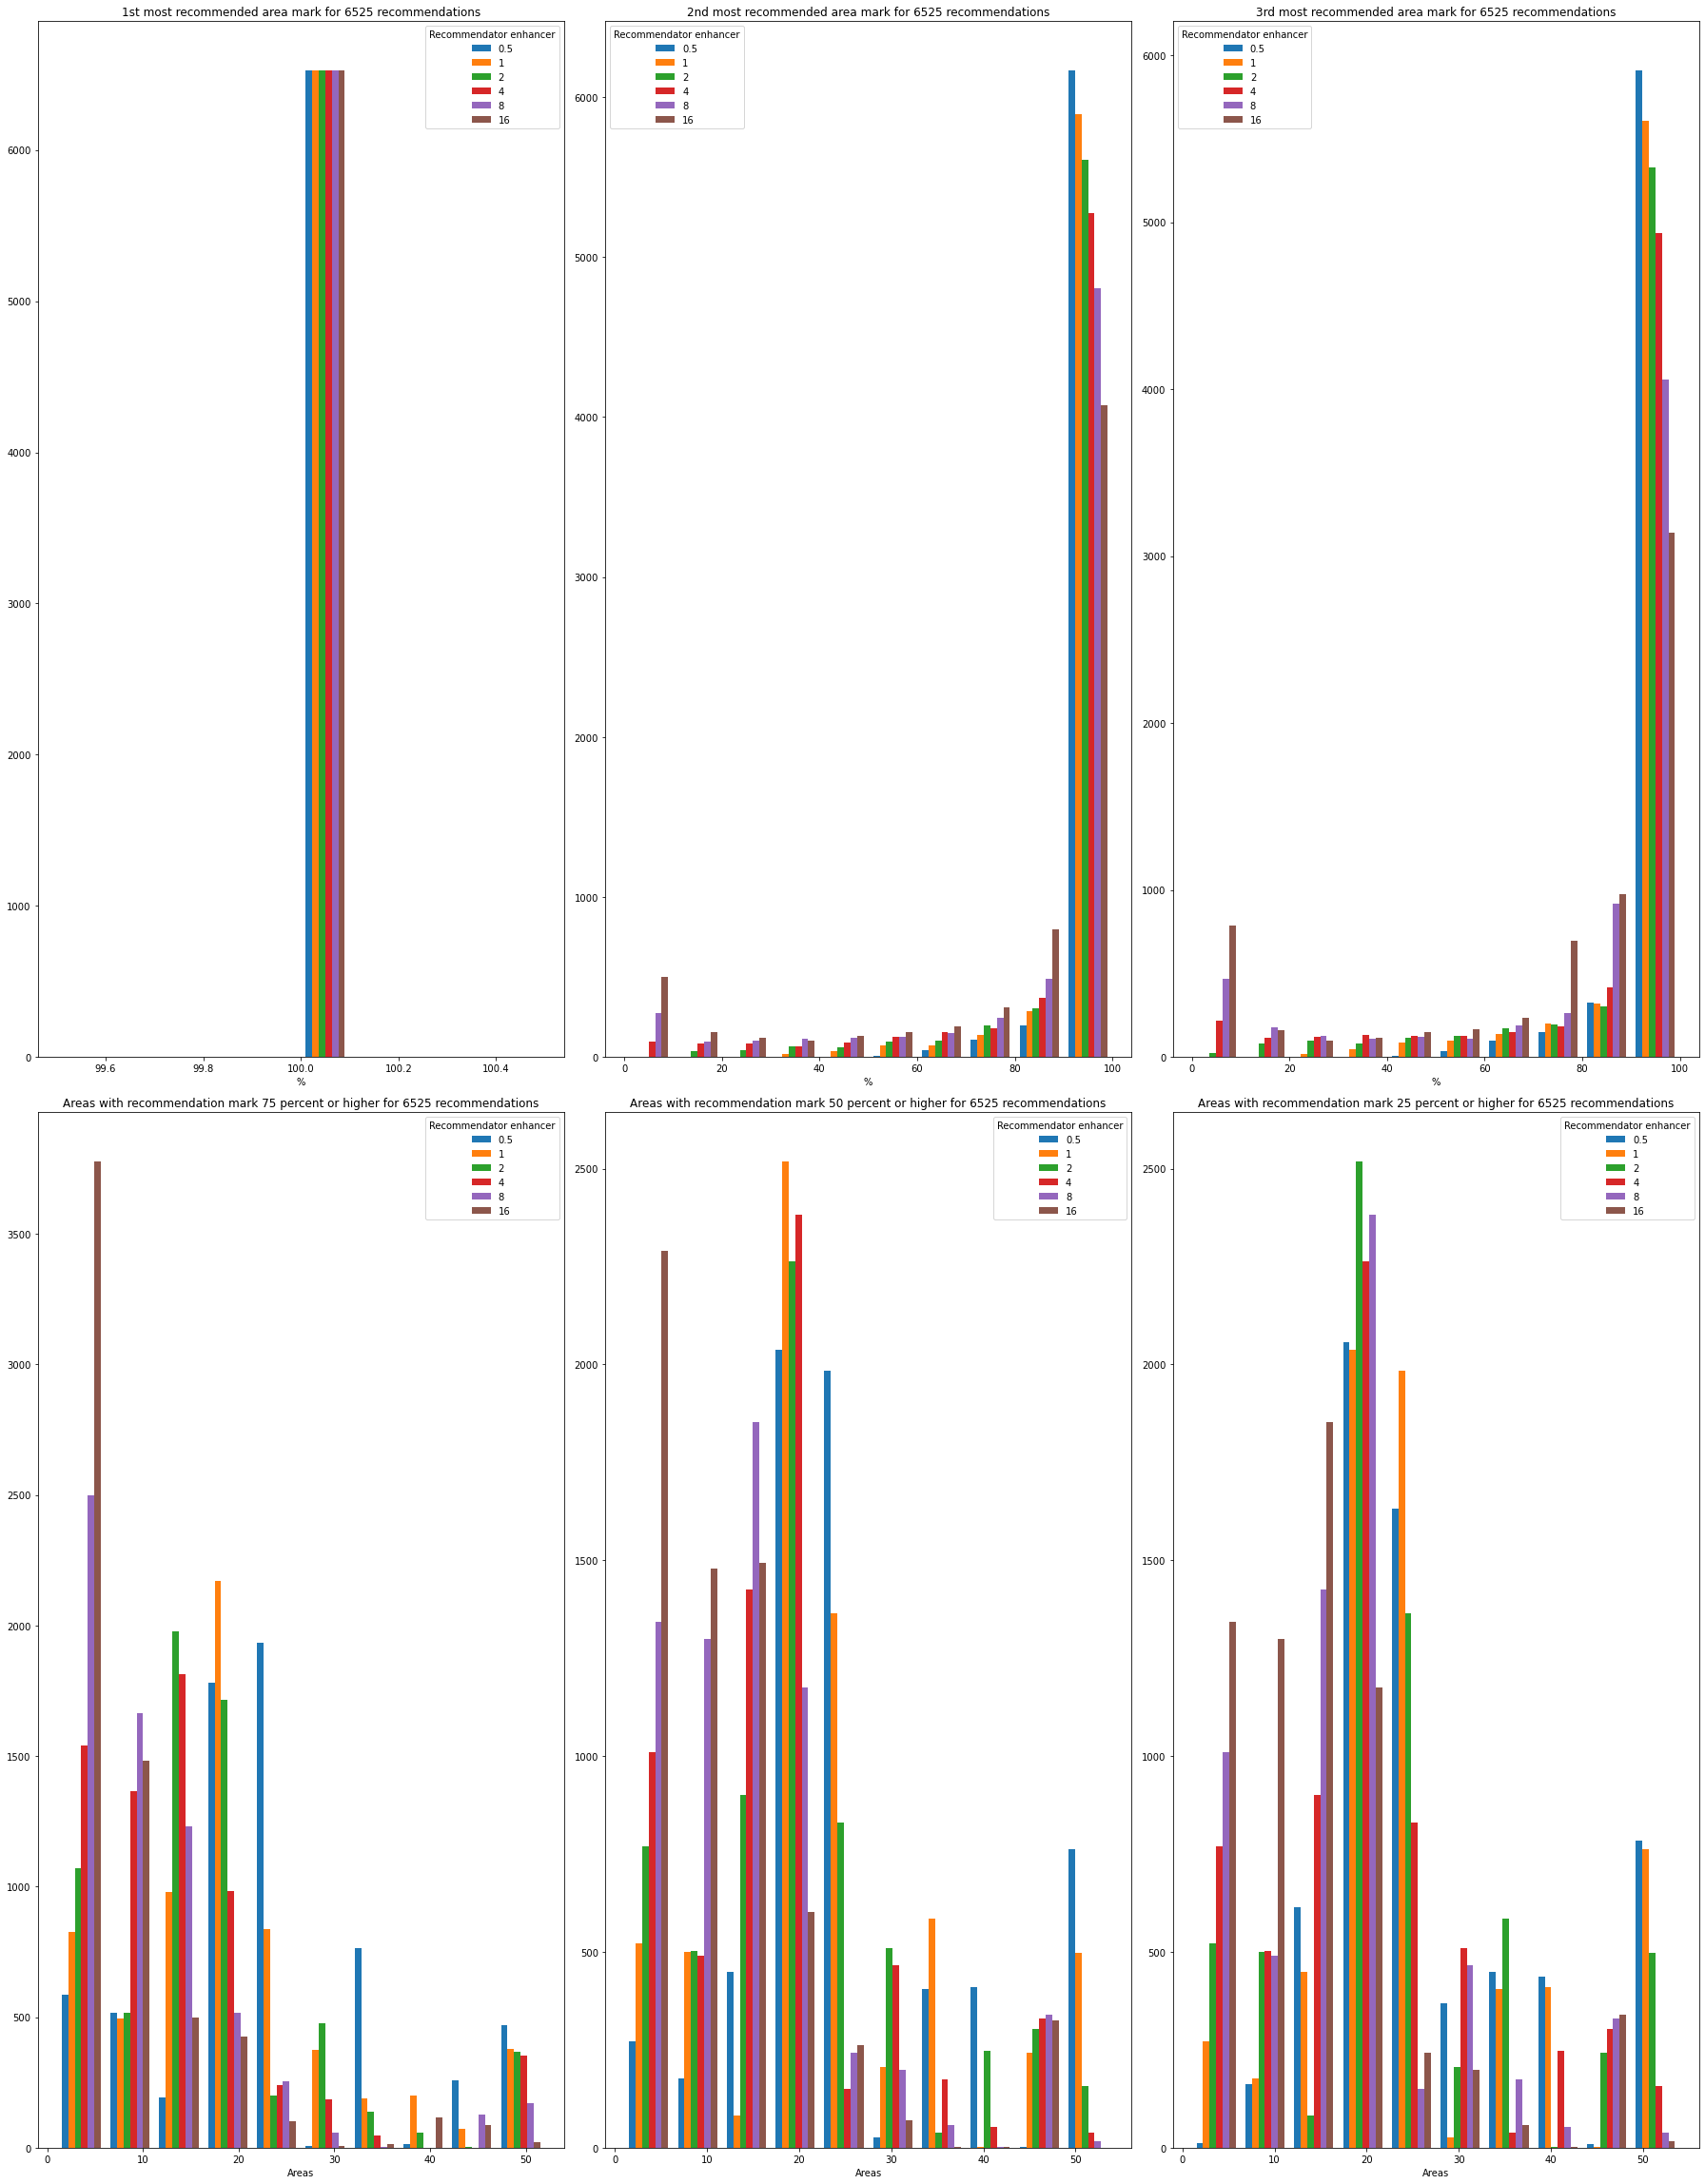

In [754]:
total_tests = df_spain_postcodes.shape[0]*df_spain_cities.shape[0]

fig, axs = plt.subplots(2,3, figsize=(25, 32))

titles = [
    "1st most recommended area mark for %d recommendations" %total_tests,
    "2nd most recommended area mark for %d recommendations" %total_tests,
    "3rd most recommended area mark for %d recommendations" %total_tests,
    "Areas with recommendation mark 75 percent or higher for %d recommendations" %total_tests,
    "Areas with recommendation mark 50 percent or higher for %d recommendations" %total_tests,
    "Areas with recommendation mark 25 percent or higher for %d recommendations" %total_tests
]

x_label = [
    "%",
    "%",
    "%",
    "Areas",
    "Areas",
    "Areas"
]

data = [
    first_recommendation_marks,
    second_recommendation_marks,
    third_recommendation_marks,
    recommendation_marks_over_75,
    recommendation_marks_over_50,
    recommendation_marks_over_25
]

axs = axs.ravel()
for idx,ax in enumerate(axs):
    ax.hist(data[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(x_label[idx])
    ax.legend(recommendator_possible_enhancers, title='Recommendator enhancer')
plt.tight_layout()

From these histograms the following conclussions can be extracted:
- All recommendator enhancers provides a recommendation mark of 100% for the best area, confirming the good working of the recommendation algorithm according to the description done.
- The top 3 areas recommended are generally giving a high value (>90) with all enhancer values tested, being these value inversely proportional to the enhancer value.
- The number of areas recommended with >75% of recommendation rate is smaller with bigger enhancer values.

As the target is to give a clear recommendation, with all options available to be checked but few options with high recommendation marks given (5 or so if possible), but still with some differences variety in the recommendation marks, <b>the recommendator enhancer value chosen for the similarity criterium will be 8</b>.

Now let's go with the similarity marks comparison for similarity criterium:

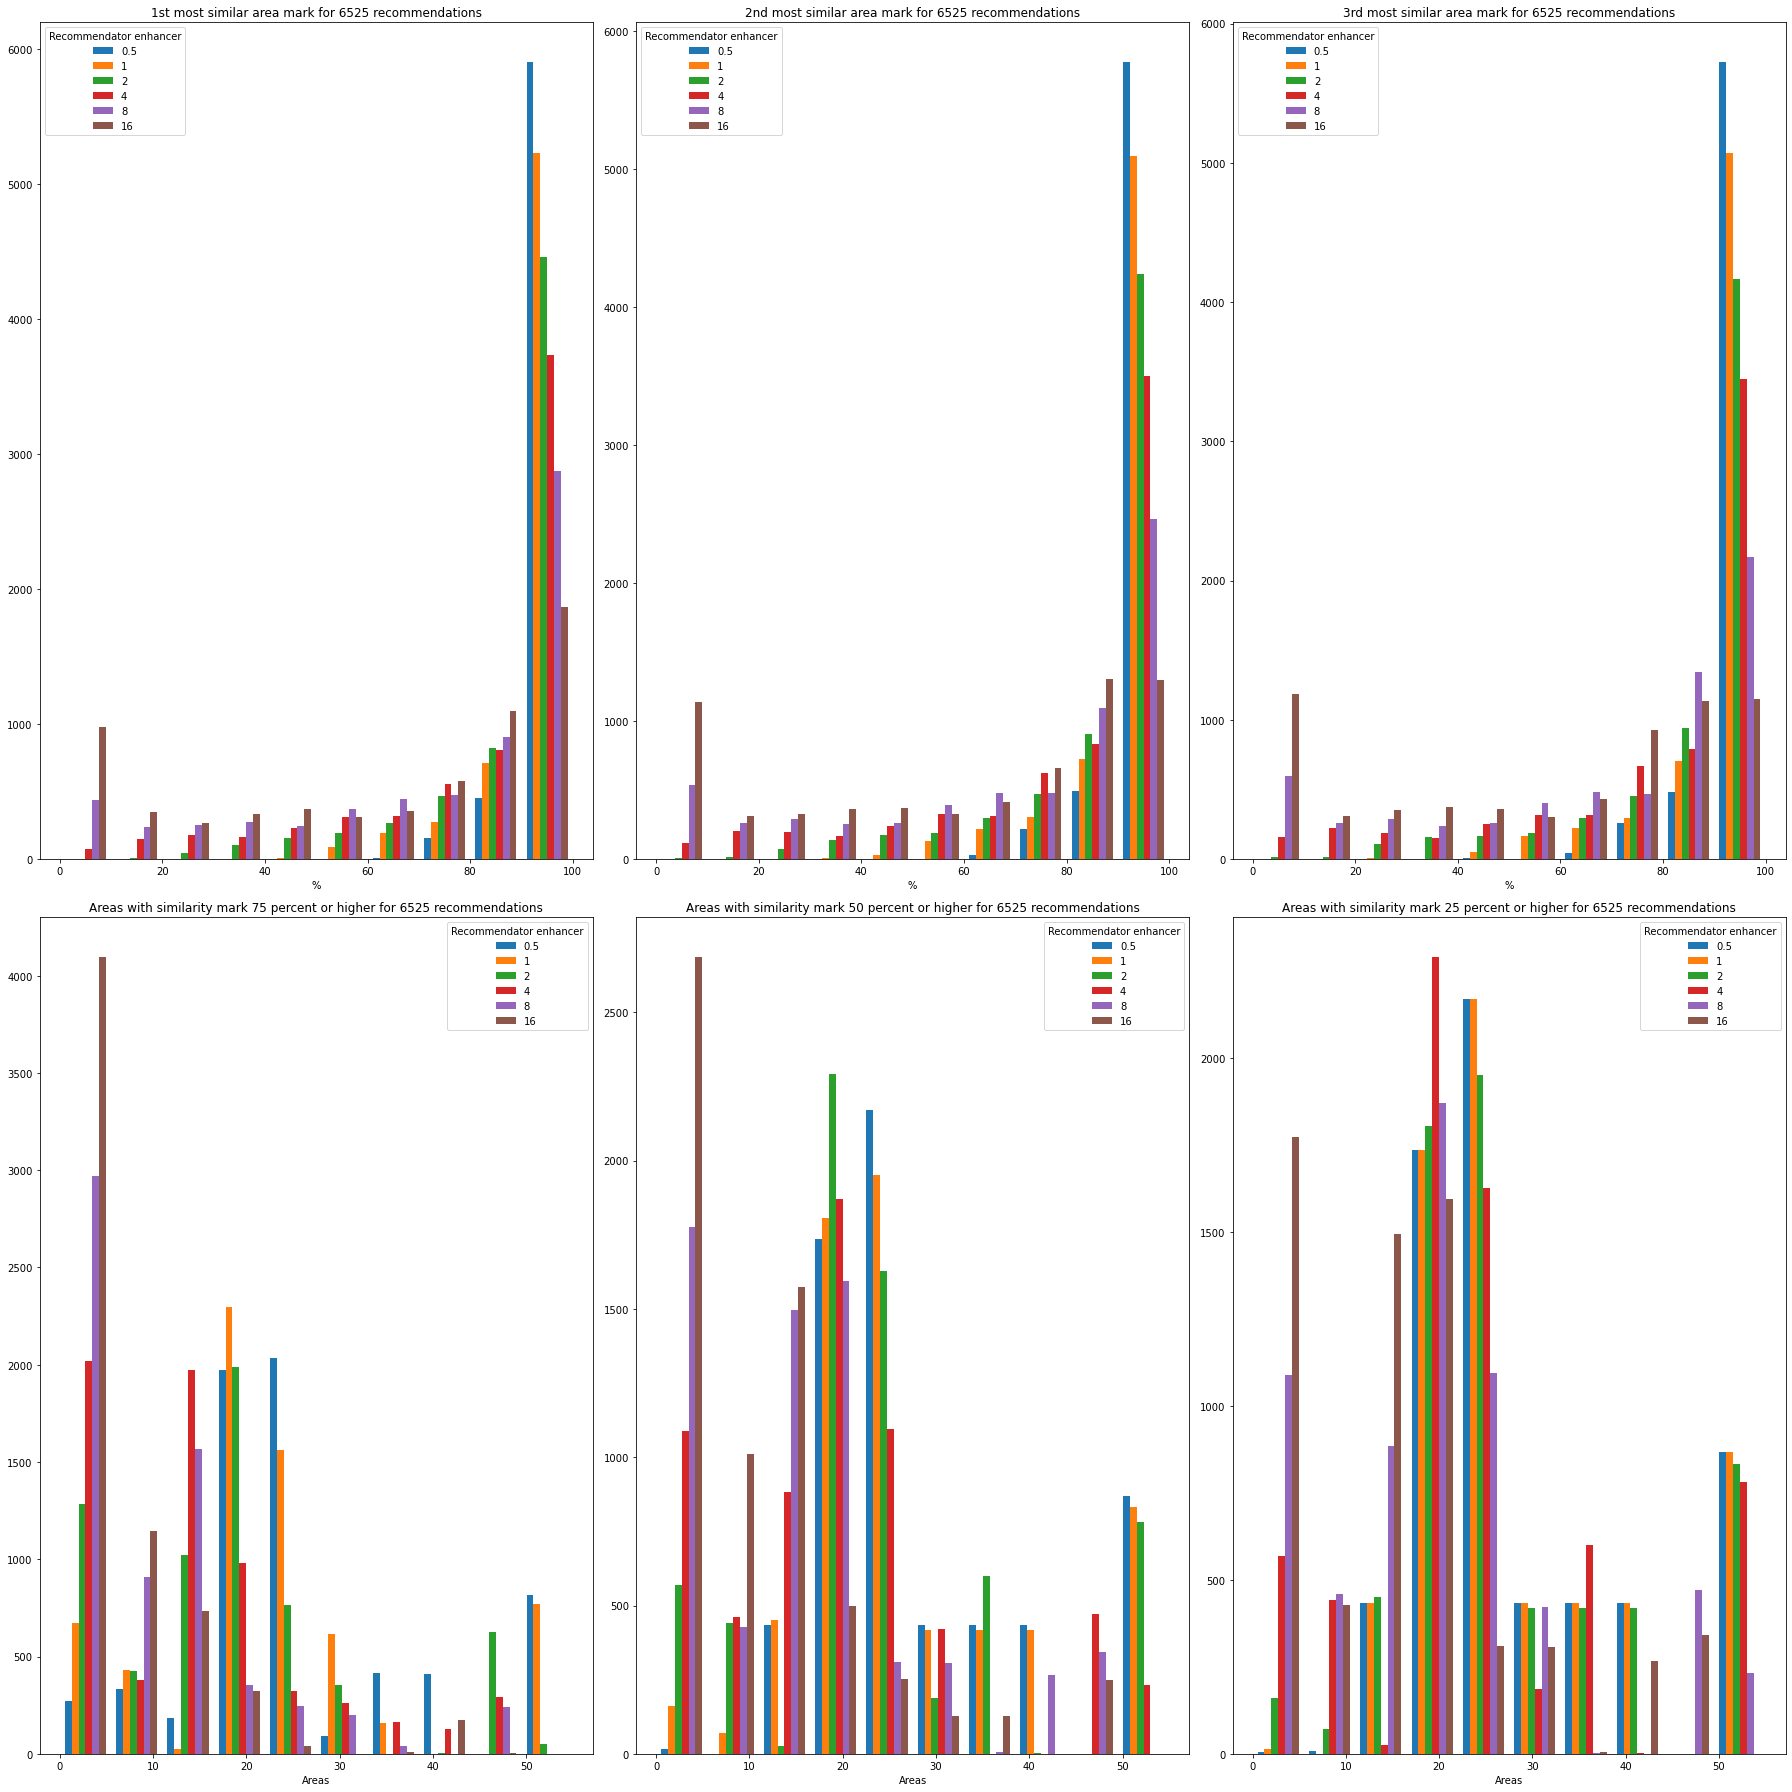

In [755]:
total_tests = df_spain_postcodes.shape[0]*df_spain_cities.shape[0]

fig, axs = plt.subplots(2,3, figsize=(25, 25))

titles = [
    "1st most similar area mark for %d recommendations" %total_tests,
    "2nd most similar area mark for %d recommendations" %total_tests,
    "3rd most similar area mark for %d recommendations" %total_tests,
    "Areas with similarity mark 75 percent or higher for %d recommendations" %total_tests,
    "Areas with similarity mark 50 percent or higher for %d recommendations" %total_tests,
    "Areas with similarity mark 25 percent or higher for %d recommendations" %total_tests
]

x_label = [
    "%",
    "%",
    "%",
    "Areas",
    "Areas",
    "Areas"
]

data = [
    first_similarity_marks,
    second_similarity_marks,
    third_similarity_marks,
    similarity_marks_over_75,
    similarity_marks_over_50,
    similarity_marks_over_25
]

axs = axs.ravel()
for idx,ax in enumerate(axs):
    ax.hist(data[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(x_label[idx])
    ax.legend(recommendator_possible_enhancers, title='Recommendator enhancer')
plt.tight_layout()

From these histograms the following conclussions can be extracted:
- The top 3 areas recommended are giving a recommendation mark inversely proportional to the enhancer value. High enhancer values provides a lot of top similarity scores with small similarity marks, while small enhancer values provides small top marks.
- The number of areas recommended with >75% of recommendation rate is smaller with bigger enhancer values, with very few areas with high similarity mark with high values, while with low enhancer values it's common to find a lot of areas with high similarity mark.

As the similarity value is estrictly informative, it does not affect the recommendation mark and it's assumed all postal codes are similar between them up to a point (they all are postal code areas of relatively big cities of Spain), but a small enhancer value makes the similarity marks too high, it's recommendatble to choose an average value. Taking into account this, <b>the similarity enhancer value chosen for the similarity criterium will be 4</b>.

Now let's go with the recommendation marks comparison for density criterium:

In [756]:
recommendator_possible_enhancers = [0.5, 1, 2, 4, 8, 16]
first_recommendation_marks=[[], [], [], [], [], []]
second_recommendation_marks=[[], [], [], [], [], []]
third_recommendation_marks=[[], [], [], [], [], []]
recommendation_marks_over_75=[[], [], [], [], [], []]
recommendation_marks_over_50=[[], [], [], [], [], []]
recommendation_marks_over_25=[[], [], [], [], [], []]

for index, city in df_spain_cities.iterrows():
    df_postcodes_to_consider = df_spain_postcodes[df_spain_postcodes["city"] == city["city"]].reset_index(drop=True)
    df_postcodes_density_venues_to_consider = df_spain_postcodes_density_venues[df_spain_postcodes_density_venues.postal_code.isin(df_postcodes_to_consider["postal_code"].values.tolist())].reset_index(drop=True)
    for index, recommendator_enh in enumerate(recommendator_possible_enhancers):
        recommendation_table, density_table = createRecommendatorArray(
            dataframe=df_postcodes_density_venues_to_consider, 
            reference=None, 
            criterium='density', 
            recommendator_enhancer=recommendator_enh,
            venues = None)
        recommendation_table_sorted = np.sort(recommendation_table, axis=None)  
        first_recommendation_marks[index].append(recommendation_table_sorted[-1])
        second_recommendation_marks[index].append(recommendation_table_sorted[-2])
        third_recommendation_marks[index].append(recommendation_table_sorted[-3])
        recommendation_marks_over_75[index].append(recommendation_table_sorted[recommendation_table_sorted>=75].shape[0])
        recommendation_marks_over_50[index].append(recommendation_table_sorted[recommendation_table_sorted>=50].shape[0])
        recommendation_marks_over_25[index].append(recommendation_table_sorted[recommendation_table_sorted>=25].shape[0])


It has worked without problems, so the recommendation algorithm is successfully tested for the density criterium.

Now the histogram of the info gathered from all recommendations done will be compared by using histograms of the the recommendation marks for density criterium:

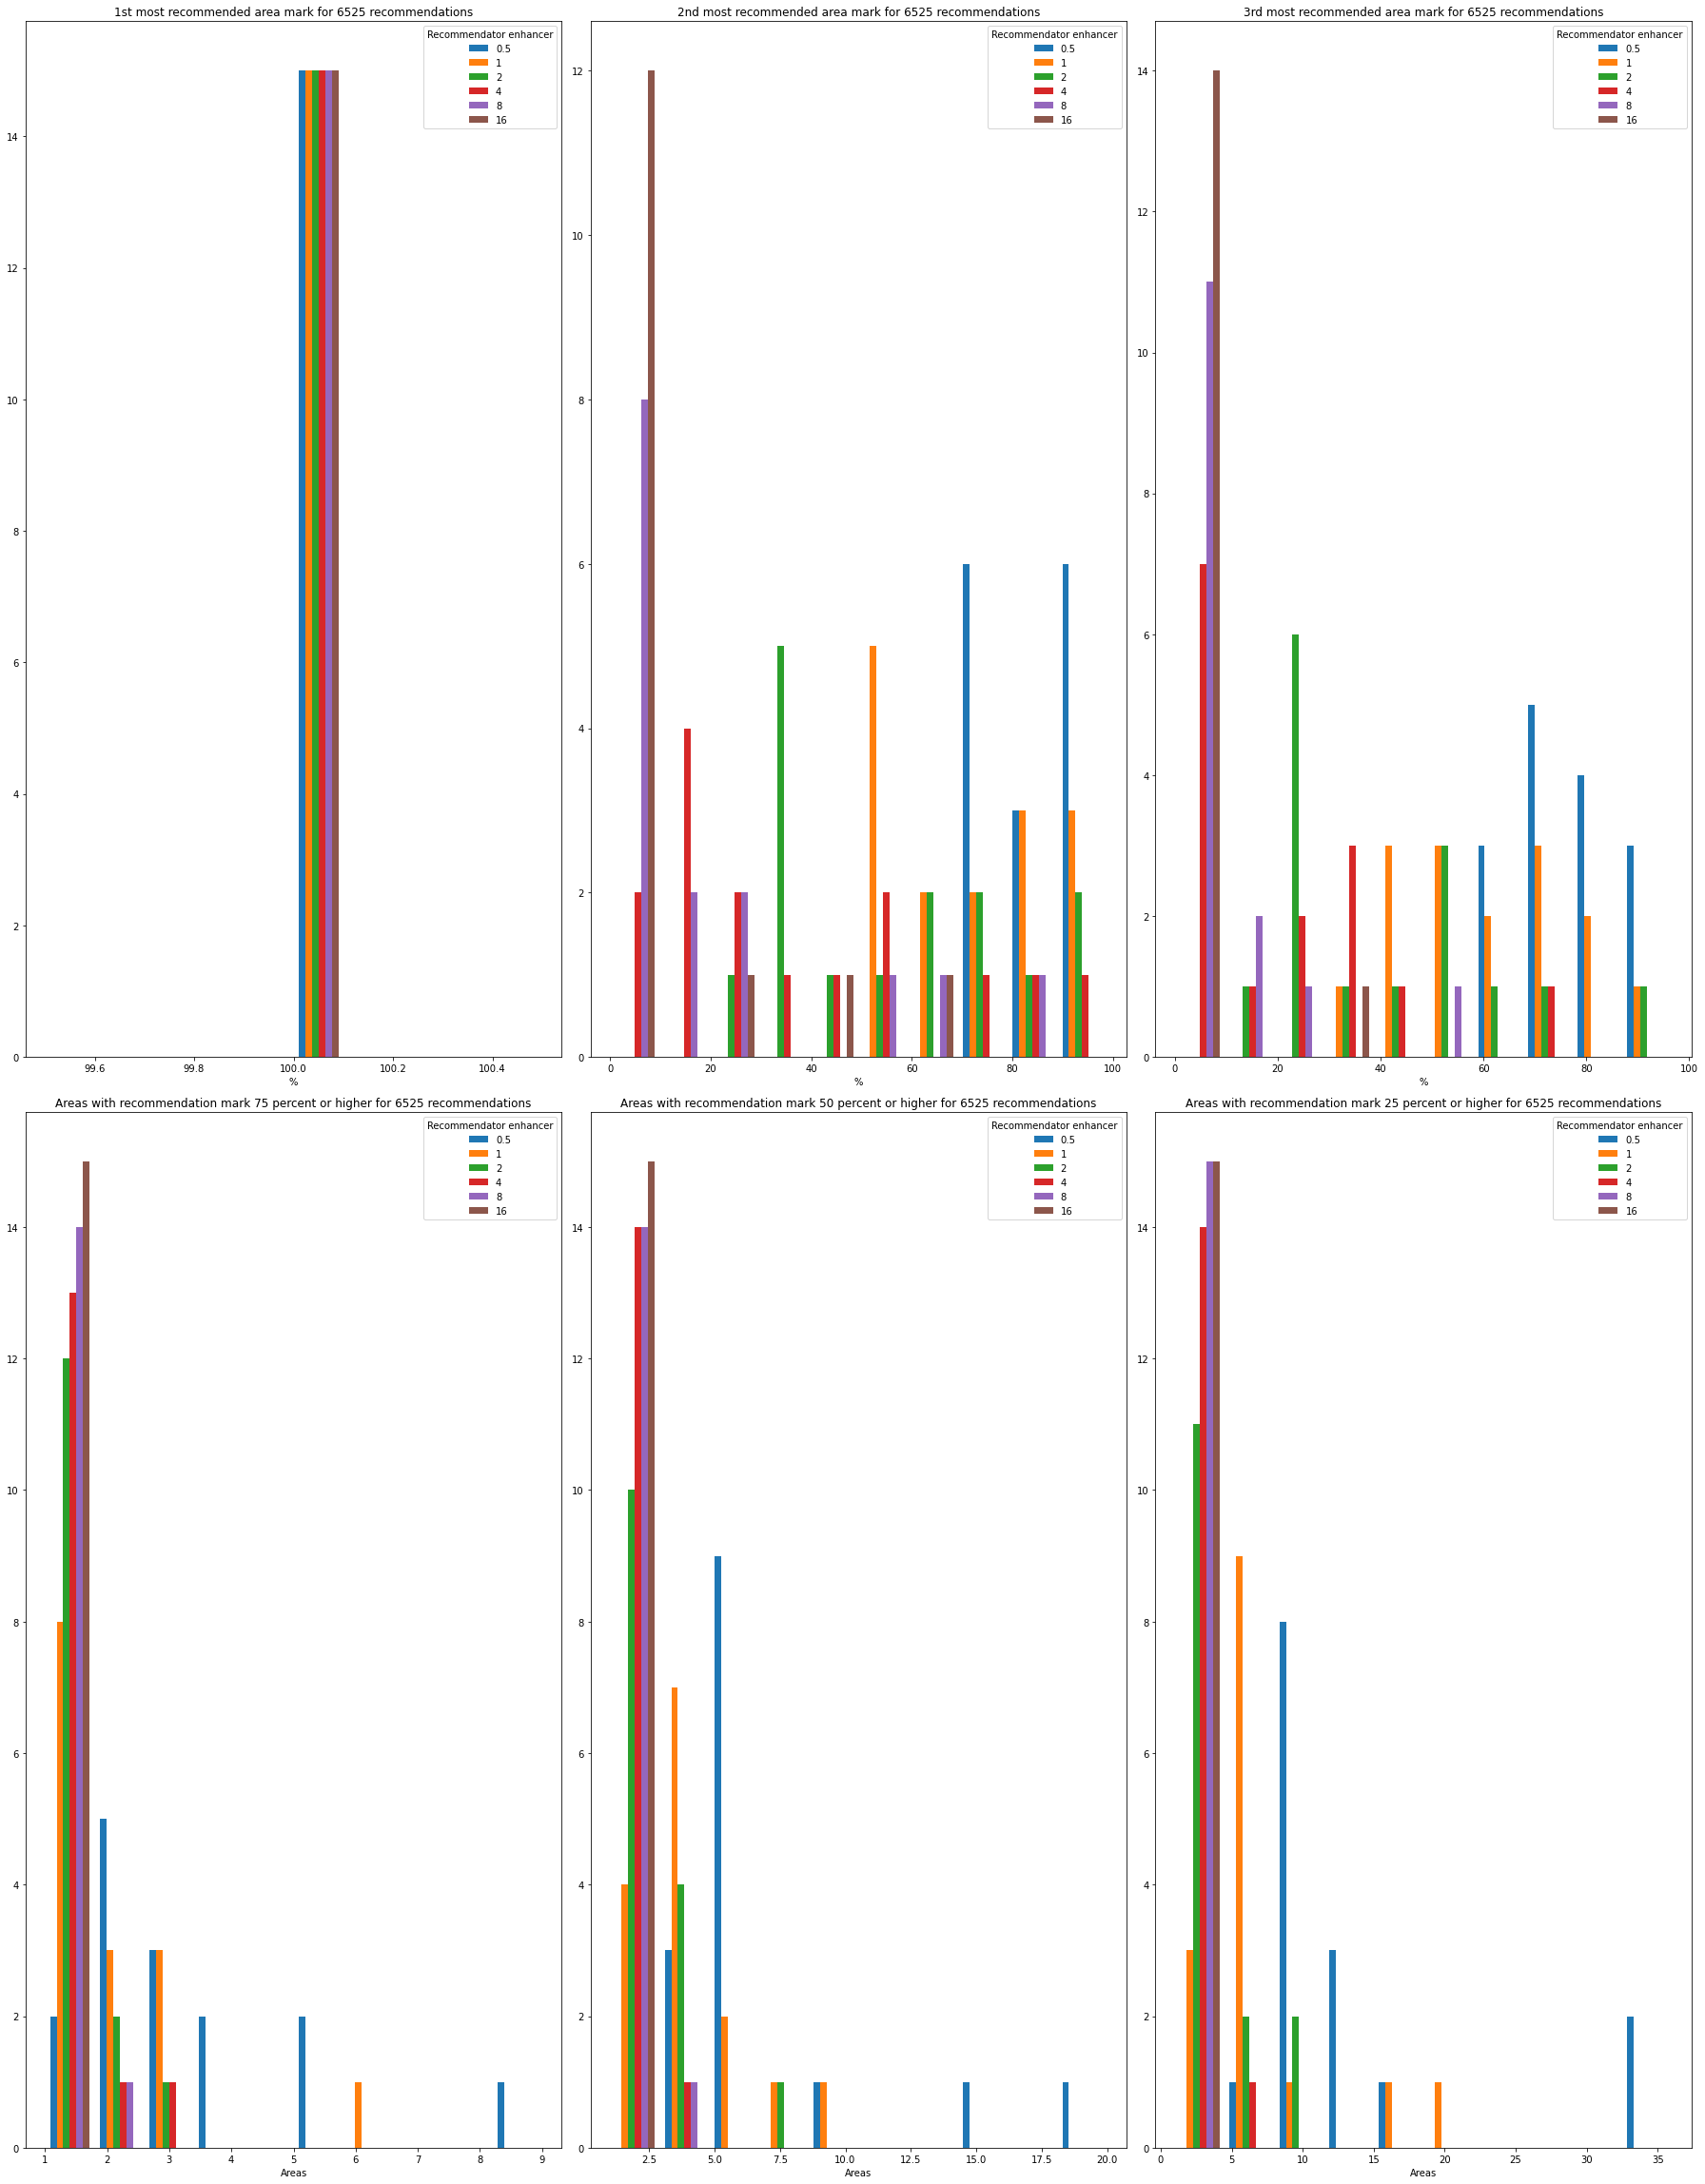

In [757]:
total_tests = df_spain_postcodes.shape[0]*df_spain_cities.shape[0]

fig, axs = plt.subplots(2,3, figsize=(25, 32))

titles = [
    "1st most recommended area mark for %d recommendations" %total_tests,
    "2nd most recommended area mark for %d recommendations" %total_tests,
    "3rd most recommended area mark for %d recommendations" %total_tests,
    "Areas with recommendation mark 75 percent or higher for %d recommendations" %total_tests,
    "Areas with recommendation mark 50 percent or higher for %d recommendations" %total_tests,
    "Areas with recommendation mark 25 percent or higher for %d recommendations" %total_tests
]

x_label = [
    "%",
    "%",
    "%",
    "Areas",
    "Areas",
    "Areas"
]

data = [
    first_recommendation_marks,
    second_recommendation_marks,
    third_recommendation_marks,
    recommendation_marks_over_75,
    recommendation_marks_over_50,
    recommendation_marks_over_25
]

axs = axs.ravel()
for idx,ax in enumerate(axs):
    ax.hist(data[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(x_label[idx])
    ax.legend(recommendator_possible_enhancers, title='Recommendator enhancer')
plt.tight_layout()

From these histograms the following conclussions can be extracted:
- All recommendator enhancers provides a recommendation mark of 100% for the best area, confirming the good working of the recommendation algorithm according to the description done.
- The second and third highest recommendation marks used to be small with higher values like 8 and 16.
- The number of areas recommended with >75% of recommendation rate is smaller with bigger enhancer values.

As the target is to give a clear recommendation, with few options available to be checked but with at least some of them with a higher value, it's better to take a small value based on the data shown. Based on this, <b>the recommendator enhancer value chosen for the similarity criterium will be 1/2</b>, because that value will give between 2 and 5 recommendations over 75% most of times.

<a id="build-visualizer"></a>
### 3.E. Build visualizer

Once build the function implementing the recommendation algorithm, a visualization tool needs to be provided in order to get a recommendation from a few inputs.

As visualization tool, two functions will be implemented.
- Both functions will show a chloropeth map of a city chosen to move in, remarking the postal code areas of the city with a green color scale, being the darkest postal code areas the most recommended ones for living taking into account the criterium chosen, the postal code chosen as reference and the venue categories the user is interested in.
- The maps generated by both functions will show tooltips when the mouse is placed over the area, showing the postal code ID, the recommendation mark for this postal code and the similarity mark (in case of similarity criterium) or the density of venues (in case of density venue).

The first step will be to get the datasets required from the CSV files created previously.

In [758]:
df_spain_cities = pd.read_csv("processed_data/df_spain_cities.csv", index_col=0)
df_spain_postcodes = pd.read_csv("processed_data/df_spain_postcodes.csv", index_col=0)
df_spain_postcodes_density_venues = pd.read_csv("processed_data/df_spain_postcodes_density_venues.csv", index_col=0)

The first function will be used in case of similarity criterium chosen, and its inputs are:
- postal_code: postal code used as reference (normally the one where the user is currently living).
- city_to_movein: city to be shown on the map and whose postal codes will be given a similarity and a recommendation mark (normally the city where the user wants to move in).
- venues_selected: Venue categories that will be taken into account for creating the similarity and the recommendation marks (normally the venue categories the user is interested in).

In [759]:
# defining update maps functions for similarity option
def show_map_similarity(postal_code, city_to_movein, venues_selected):
    if (postal_code is None) or (len(postal_code) == 0):
        display(HTML('<b style="font-size:35px; margin:20px;" >You must select a postal code</b>'))
        return
    if (city_to_movein is None) or (len(city_to_movein) == 0):
        display(HTML('<b style="font-size:35px; margin:20px;" >You must select a city to move in</b>'))
        return
    if venues_selected is not None:
        venues_selected = list(venues_selected)
    
    df_postcodes_to_consider = df_spain_postcodes[df_spain_postcodes["city"] == city_to_movein].reset_index(drop=True)
    df_postcodes_density_venues_to_consider = df_spain_postcodes_density_venues[df_spain_postcodes_density_venues.postal_code.isin(df_postcodes_to_consider["postal_code"].values.tolist())].reset_index(drop=True)
    df_density_venues_reference = df_spain_postcodes_density_venues[df_spain_postcodes_density_venues.postal_code == int(postal_code)]

    similarity_reference_to_apply = workoutSimilarityReference(df_spain_postcodes_density_venues, venues_selected)

    recommendation_table, similarity_table = createRecommendatorArray(
        dataframe=df_postcodes_density_venues_to_consider, 
        reference=df_density_venues_reference,
        criterium='similarity', 
        similarity_reference=similarity_reference_to_apply,
        recommendator_enhancer=8,
        similarity_enhancer=4,
        venues = venues_selected)

    if (recommendation_table is None) or (np.max(recommendation_table) == 0.0):
        display(HTML('<b style="font-size:35px; margin:20px;" >Not enough venues selected for making a recommentation</b>'))
        return

    df_postcodes_to_consider.insert(6, 'recommendation_mark', recommendation_table)
    df_postcodes_to_consider.insert(7, 'similarity_mark', similarity_table)
    df_postcodes_to_consider.astype({'postal_code': str})
    df_postcodes_density_venues_to_consider.astype({'postal_code': str})

    colormap = linear.YlGn_09.scale(0, 100)

    # create city map
    latitude = df_spain_cities[df_spain_cities["city"] == city_to_movein]["latitude"].iloc[0]
    longitude = df_spain_cities[df_spain_cities["city"] == city_to_movein]["longitude"].iloc[0]

    geojson_file = "processed_data/geojson/" + df_spain_cities[df_spain_cities["city"] == city_to_movein]["geojson_file"].iloc[0]
    with open(geojson_file, "r") as f:
        geojson = json.load(f)
    for feature in geojson["features"]:
        recommendation_mark = df_postcodes_to_consider[df_postcodes_to_consider.postal_code == int(feature["properties"]["COD_POSTAL"])]['recommendation_mark'].iloc[0]
        similarity_mark = df_postcodes_to_consider[df_postcodes_to_consider.postal_code == int(feature["properties"]["COD_POSTAL"])]['similarity_mark'].iloc[0]
        feature["properties"]["RECOMMENDATION_MARK"] = round(recommendation_mark,2)
        feature["properties"]["SIMILARITY_MARK"] = round(similarity_mark,2)

    map_city = folium.Map(location=[latitude, longitude], zoom_start=12)

    folium.GeoJson(
        geojson,
        name="recommendation",
        style_function=lambda feature: {
            "fillColor": colormap(feature["properties"]["RECOMMENDATION_MARK"]),
            "color": "black",
            "weight": 1,
            "dashArray": "5, 5",
            "fillOpacity": 0.5,
        },
        tooltip=folium.features.GeoJsonTooltip(
            fields=[
                'COD_POSTAL',
                'RECOMMENDATION_MARK',
                'SIMILARITY_MARK',
            ],
            aliases=[
                'Postal code: ',
                'Recommendation score (%): ', 
                'Similarity (%): ', 
            ],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
            )).add_to(map_city)

    colormap.caption = "Recommendation level (%)"
    colormap.add_to(map_city)

    display(map_city)


Let's test the visualizer function for similarity criterium with a test:

In [760]:
show_map_similarity("3001", "Valladolid", None)

The second function will be used in case of density criterium chosen, and its inputs are:
- city_to_movein: city to be shown on the map and whose postal codes will be given the density of venues and a recommendation mark (normally the city where the user wants to move in).
- venues_selected: Venue categories that will be taken into account for getting the density of venues and creating the recommendation marks (normally the venue categories the user is interested in).

In [761]:
# defining update maps functions for similarity option
def show_map_density(city_to_movein, venues_selected):
    if (city_to_movein is None) or (len(city_to_movein) == 0):
        display(HTML('<b style="font-size:35px; margin:20px;" >You must select a city to move in</b>'))
        return
    if venues_selected is not None:
        venues_selected = list(venues_selected)
    
    df_postcodes_to_consider = df_spain_postcodes[df_spain_postcodes["city"] == city_to_movein].reset_index(drop=True)
    df_postcodes_density_venues_to_consider = df_spain_postcodes_density_venues[df_spain_postcodes_density_venues.postal_code.isin(df_postcodes_to_consider["postal_code"].values.tolist())].reset_index(drop=True)
    
    recommendation_table, density_table = createRecommendatorArray(
        dataframe=df_postcodes_density_venues_to_consider, 
        reference=None, 
        criterium='density', 
        recommendator_enhancer=1/2,
        venues = venues_selected)

    df_postcodes_to_consider.insert(6, 'recommendation_mark', recommendation_table)
    df_postcodes_to_consider.insert(6, 'density', density_table)
    df_postcodes_to_consider.astype({'postal_code': str})
    df_postcodes_density_venues_to_consider.astype({'postal_code': str})

    colormap = linear.YlGn_09.scale(0, 100)

    # create city map
    latitude = df_spain_cities[df_spain_cities["city"] == city_to_movein]["latitude"].iloc[0]
    longitude = df_spain_cities[df_spain_cities["city"] == city_to_movein]["longitude"].iloc[0]

    geojson_file = "processed_data/geojson/" + df_spain_cities[df_spain_cities["city"] == city_to_movein]["geojson_file"].iloc[0]
    with open(geojson_file, "r") as f:
        geojson = json.load(f)
    for feature in geojson["features"]:
        recommendation_mark = df_postcodes_to_consider[df_postcodes_to_consider.postal_code == int(feature["properties"]["COD_POSTAL"])]['recommendation_mark'].iloc[0]
        feature["properties"]["RECOMMENDATION_MARK"] = round(recommendation_mark,2)
        density = df_postcodes_to_consider[df_postcodes_to_consider.postal_code == int(feature["properties"]["COD_POSTAL"])]['density'].iloc[0]
        feature["properties"]["DENSITY"] = round(density,2)

    map_city = folium.Map(location=[latitude, longitude], zoom_start=12)

    folium.GeoJson(
        geojson,
        name="recommendation",
        style_function=lambda feature: {
            "fillColor": colormap(feature["properties"]["RECOMMENDATION_MARK"]),
            "color": "black",
            "weight": 1,
            "dashArray": "5, 5",
            "fillOpacity": 0.5,
        },
        tooltip=folium.features.GeoJsonTooltip(
            fields=[
                'COD_POSTAL',
                'RECOMMENDATION_MARK',
                'DENSITY',
            ],
            aliases=[
                'Postal code: ',
                'Recommendation score (%): ', 
                'Density (venues/Km2): ',
            ],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
            )).add_to(map_city)

    colormap.caption = "Recommendation level (%)"
    colormap.add_to(map_city)

    display(map_city)


Let's test the visualizer function for density criterium with a test:

In [785]:
show_map_density("Valladolid", ())

<a id="build-application"></a>
### 3.F. Build application

Finally, with the recommendation algorithm and visualizer functions yet implemented, it's time for creating an application using those functions in order to create a simple interface the user can interact with in order to get the recommendations desired.

For creating the application, Ipython module classes will be used, allowing to create an application the user can interact with.

In [763]:
# Getting lists used as inputs for selectors
venues_available = df_spain_postcodes_density_venues.columns.tolist()
venues_available.remove('postal_code')
postal_codes_available = [str(element) for element in df_spain_postcodes["postal_code"].values.tolist()]
cities_available = df_spain_cities['city'].values.tolist()

# creating the combo selection widgets for density
postal_code_selector_widget_similarity = widgets.Combobox(
    # value='John',
    placeholder='Postal code',
    options=postal_codes_available,
    ensure_option=True,
    disabled=False,
    layout = widgets.Layout(width='99%')
)
city_to_movein_selector_widget_similarity = widgets.Combobox(
    # value='John',
    placeholder='City',
    options=cities_available,
    ensure_option=True,
    disabled=False,
    layout = widgets.Layout(width='99%')
)
venues_selector_widget_similarity = widgets.SelectMultiple(
    options = venues_available,
    value = venues_available,
    disabled=False,
    layout = widgets.Layout(width='99%', height='80px')
)
button_select_all_similarity = widgets.Button(description = 'Select all')
def select_all_similarity(*args):
    venues_selector_widget_similarity.value = venues_selector_widget_similarity.options
button_select_all_similarity.on_click(select_all_similarity)

# creating the combo selection widgets for density
city_to_movein_selector_widget_density = widgets.Combobox(
    # value='John',
    placeholder='City',
    options=cities_available,
    ensure_option=True,
    disabled=False,
    layout = widgets.Layout(width='99%')
)
venues_selector_widget_density = widgets.SelectMultiple(
    options = venues_available,
    value = venues_available,
    disabled=False,
    layout = widgets.Layout(width='99%', height='80px')
)
button_select_all_density = widgets.Button(description = 'Select all')
def select_all_density(*args):
    venues_selector_widget_density.value = venues_selector_widget_density.options
button_select_all_density.on_click(select_all_density)
                                     
# Creating app layout for similarity option tab
similarity_tab = widgets.AppLayout(header=None,
          left_sidebar=widgets.VBox([widgets.Label("Living in:"),
                             postal_code_selector_widget_similarity,
                             widgets.Label("Moving in to:"),
                             city_to_movein_selector_widget_similarity,
                             widgets.Label("Venues selected:"),
                             venues_selector_widget_similarity,
                             button_select_all_similarity]),
          center=widgets.interactive_output(show_map_similarity, 
                                     {
                                         'postal_code': postal_code_selector_widget_similarity, 
                                         'city_to_movein': city_to_movein_selector_widget_similarity, 
                                         'venues_selected': venues_selector_widget_similarity
                                     }),
          right_sidebar=None,
          footer=None)
               
# Creating app layout for density option tab
density_tab = widgets.AppLayout(header=None,
          left_sidebar=widgets.VBox([widgets.Label("Moving in to:"),
                             city_to_movein_selector_widget_density,
                             widgets.Label("Venues selected:"),
                             venues_selector_widget_density,
                             button_select_all_density]),
          center=widgets.interactive_output(show_map_density, 
                                     {
                                         'city_to_movein': city_to_movein_selector_widget_density, 
                                         'venues_selected': venues_selector_widget_density
                                     }),
          right_sidebar=None,
          footer=None)

# Creating main tab layout
tab_nest = widgets.Tab()
tab_nest.children = [similarity_tab, density_tab]
tab_nest.set_title(0, 'By similarity')
tab_nest.set_title(1, 'By density')

# Show final application
tab_nest

It can be seen that the application, although with a basic UI, works well, providing a recommendation about postal codes where to live based on information provided by the user.

<a id="results"></a>
## 9. Results

Once build and tuned the function implementing the recommendation algorithm, the visualization tools and the application to use both of them, it's time to analyze the results obtained with the recommendation system.

Though an exploratory analysis done by using the application, there are some hypothesis which according to results observed with manual testing are considered as worth to be analyzed. These are the following:

- When using the similarity criterium, there is a correlation between the relative distance of the most recommended postal code area from its city center and the relative distance of the postal code area taken as reference from its city center.
- When using the similarity criterium, there is a correlation between the venue type which is more common in the most recommended postal code area from its city center and the venue type which is more common in the postal code area taken as reference.
- When using the similarity criterium, the two previous correlations, if existing, can vary depending on the type of venues considered for doing the recommendation.
- When using the density criterium, there is a correlation between the density of venues of a postal code and the distance of the postal code from it's city center.
- When using the density criterium, the correlation, if existing, between the density of venues of a postal code and the distance of the postal code from it's city center can vary depending on the type of venues considered for doing the recommendation.

For confirming the hypothesis regarding the similarity criterium, the recommendation algorithm will be used for doing a series of recommendations. The recommendations will be done using The following categories to be considered:
- One recommendation containing all the venue categories available.
- Several recommendations, each one containing all the venue categories available with one primary category in common.

The first step will be to create these venue category lists.

In [772]:
df_spain_venues_filtered = pd.read_csv("processed_data/df_spain_venues_filtered.csv", index_col=0)
venues_primary_categories = ["Food", "Outdoors & Recreation", "Shop & Service", "Nightlife Spot", "Travel & Transport", "Arts & Entertainment",  "Professional & Other Places", "College & University", "Residence", "All"]
venues_category_combinations = {}
for primary_category in venues_primary_categories:
    if primary_category == "All":
        venues_category_combinations[primary_category] = df_spain_venues_filtered["venue_category_secondary"].unique().tolist()
    else:
        venues_category_combinations[primary_category] = df_spain_venues_filtered[df_spain_venues_filtered["venue_category_primary"] == primary_category]["venue_category_secondary"].unique().tolist()

<a id="results-similarity"></a>
### 4.A. Results for similarity criterium

For each combination of postal code area available and city available to move in, the recommendation algorithm will be used for getting a series of recommendations based on similarity, one for each of the venue recommendations lists defined to be considered. For each of these recommendations, the following data will be stored in a dataframe:
- User hypothetical input (reference postal code, city to move in and venue categories to consider).
- Distance of the reference postal code from it's city center (normalized to the influence radius of the city).
- Distance of the most recommended postal code from it's city center (normalized to the influence radius of the city).
- Both first and second venue category with the hightest density in the reference postal code.
- Both first and second venue category with the hightest density in the most referenced postal code.

In [773]:
analysis_results_similarity_criterium=[]

for index, postcode in df_spain_postcodes.iterrows():
    print("Processing area " + str(index + 1) + "/" + str(df_spain_postcodes_density_venues.shape[0]) + ": " + str(postcode['postal_code']) + ", " + postcode['city'] + "                                          \r", end="")
    for index, city in df_spain_cities.iterrows():
        if (postcode["city"] == city["city"]):
            continue
        df_postcodes_to_consider = df_spain_postcodes[df_spain_postcodes["city"] == city["city"]].reset_index(drop=True)
        df_postcodes_density_venues_to_consider = df_spain_postcodes_density_venues[df_spain_postcodes_density_venues.postal_code.isin(df_postcodes_to_consider["postal_code"].values.tolist())].reset_index(drop=True)
        df_density_venues_reference = df_spain_postcodes_density_venues[df_spain_postcodes_density_venues.postal_code == int(postcode["postal_code"])]
        for primary_venue_category_to_consider, venues_to_consider_list in venues_category_combinations.items():
            recommendation_table, similarity_table = createRecommendatorArray(
                dataframe=df_postcodes_density_venues_to_consider, 
                reference=df_density_venues_reference, 
                criterium='similarity', 
                recommendator_enhancer=8,
                similarity_enhancer=4,
                venues = venues_to_consider_list)
            index_recommended = np.where(recommendation_table == np.amax(recommendation_table))
            postcode_recommended = df_postcodes_to_consider.loc[index_recommended].reset_index()
            city_reference = df_spain_cities[df_spain_cities["city"] == postcode["city"]].reset_index()
            postcode_reference_coordinates = [postcode["postal_code_latitude"], postcode["postal_code_longitude"]]
            postcode_recommended_coordinates = [postcode_recommended.loc[0, "postal_code_latitude"], postcode_recommended.loc[0, "postal_code_longitude"]]
            city_reference_center_coordinates = [city_reference.loc[0, "latitude"], city_reference.loc[0, "longitude"]]
            city_recommended_center_coordinates = [city["latitude"], city["longitude"]]
            distance_reference = get_distance_between_coordinates(city_reference_center_coordinates, postcode_reference_coordinates)
            distance_reference_normalized = distance_reference/city_reference.loc[0, "influence_radius"]
            distance_recommended = get_distance_between_coordinates(city_recommended_center_coordinates, postcode_recommended_coordinates)
            distance_recommended_normalized = distance_recommended/city["influence_radius"]
            most_dense_cat_ref = df_density_venues_reference.drop(['postal_code'], axis=1).idxmax(axis=1).reset_index()[0][0]
            most_dense_cat_rec = df_postcodes_density_venues_to_consider.drop(['postal_code'], axis=1).loc[index_recommended].idxmax(axis=1).reset_index()[0][0]
            most_dense_firstcat_ref = translateVenueToPrimaryCategory(most_dense_cat_ref)
            most_dense_firstcat_rec = translateVenueToPrimaryCategory(most_dense_cat_rec)
            analysis_results_similarity_criterium.extend([( 
                postcode['postal_code'],
                city['city'],
                distance_reference_normalized, 
                distance_recommended_normalized, 
                most_dense_cat_ref, 
                most_dense_cat_rec,
                most_dense_firstcat_ref,
                most_dense_firstcat_rec,
                primary_venue_category_to_consider)])

# Convert the postal code list into a pandas dataframe
df_analysis_results_similarity_criterium = pd.DataFrame([item for item in analysis_results_similarity_criterium]).reset_index(drop=True)
df_analysis_results_similarity_criterium.columns = [
              'postal_code_reference', 
              'city_movein_chosen', 
              'normalized_distance_reference', 
              'normalized_distance_first_recommendation', 
              'most_dense_catogory_reference', 
              'most_dense_catogory_first_recommendation', 
              'most_dense_first_catogory_reference', 
              'most_dense_first_catogory_first_recommendation', 
              'primary_venue_category_to_consider']
print("Done!                                                                                  \r", end="")


For checking the hypothesis of the correlation between the distances from the city center of the postal code taken as reference and the most recommended postal code, the following info will be show for eacho of the venue category lists used previously:
- A scatter plot showing the relationship of both distances for all tests done with these venue category lists to be considered.
- The pearson coefficient and P-value of both distances for each of these venue category lists to be considered.

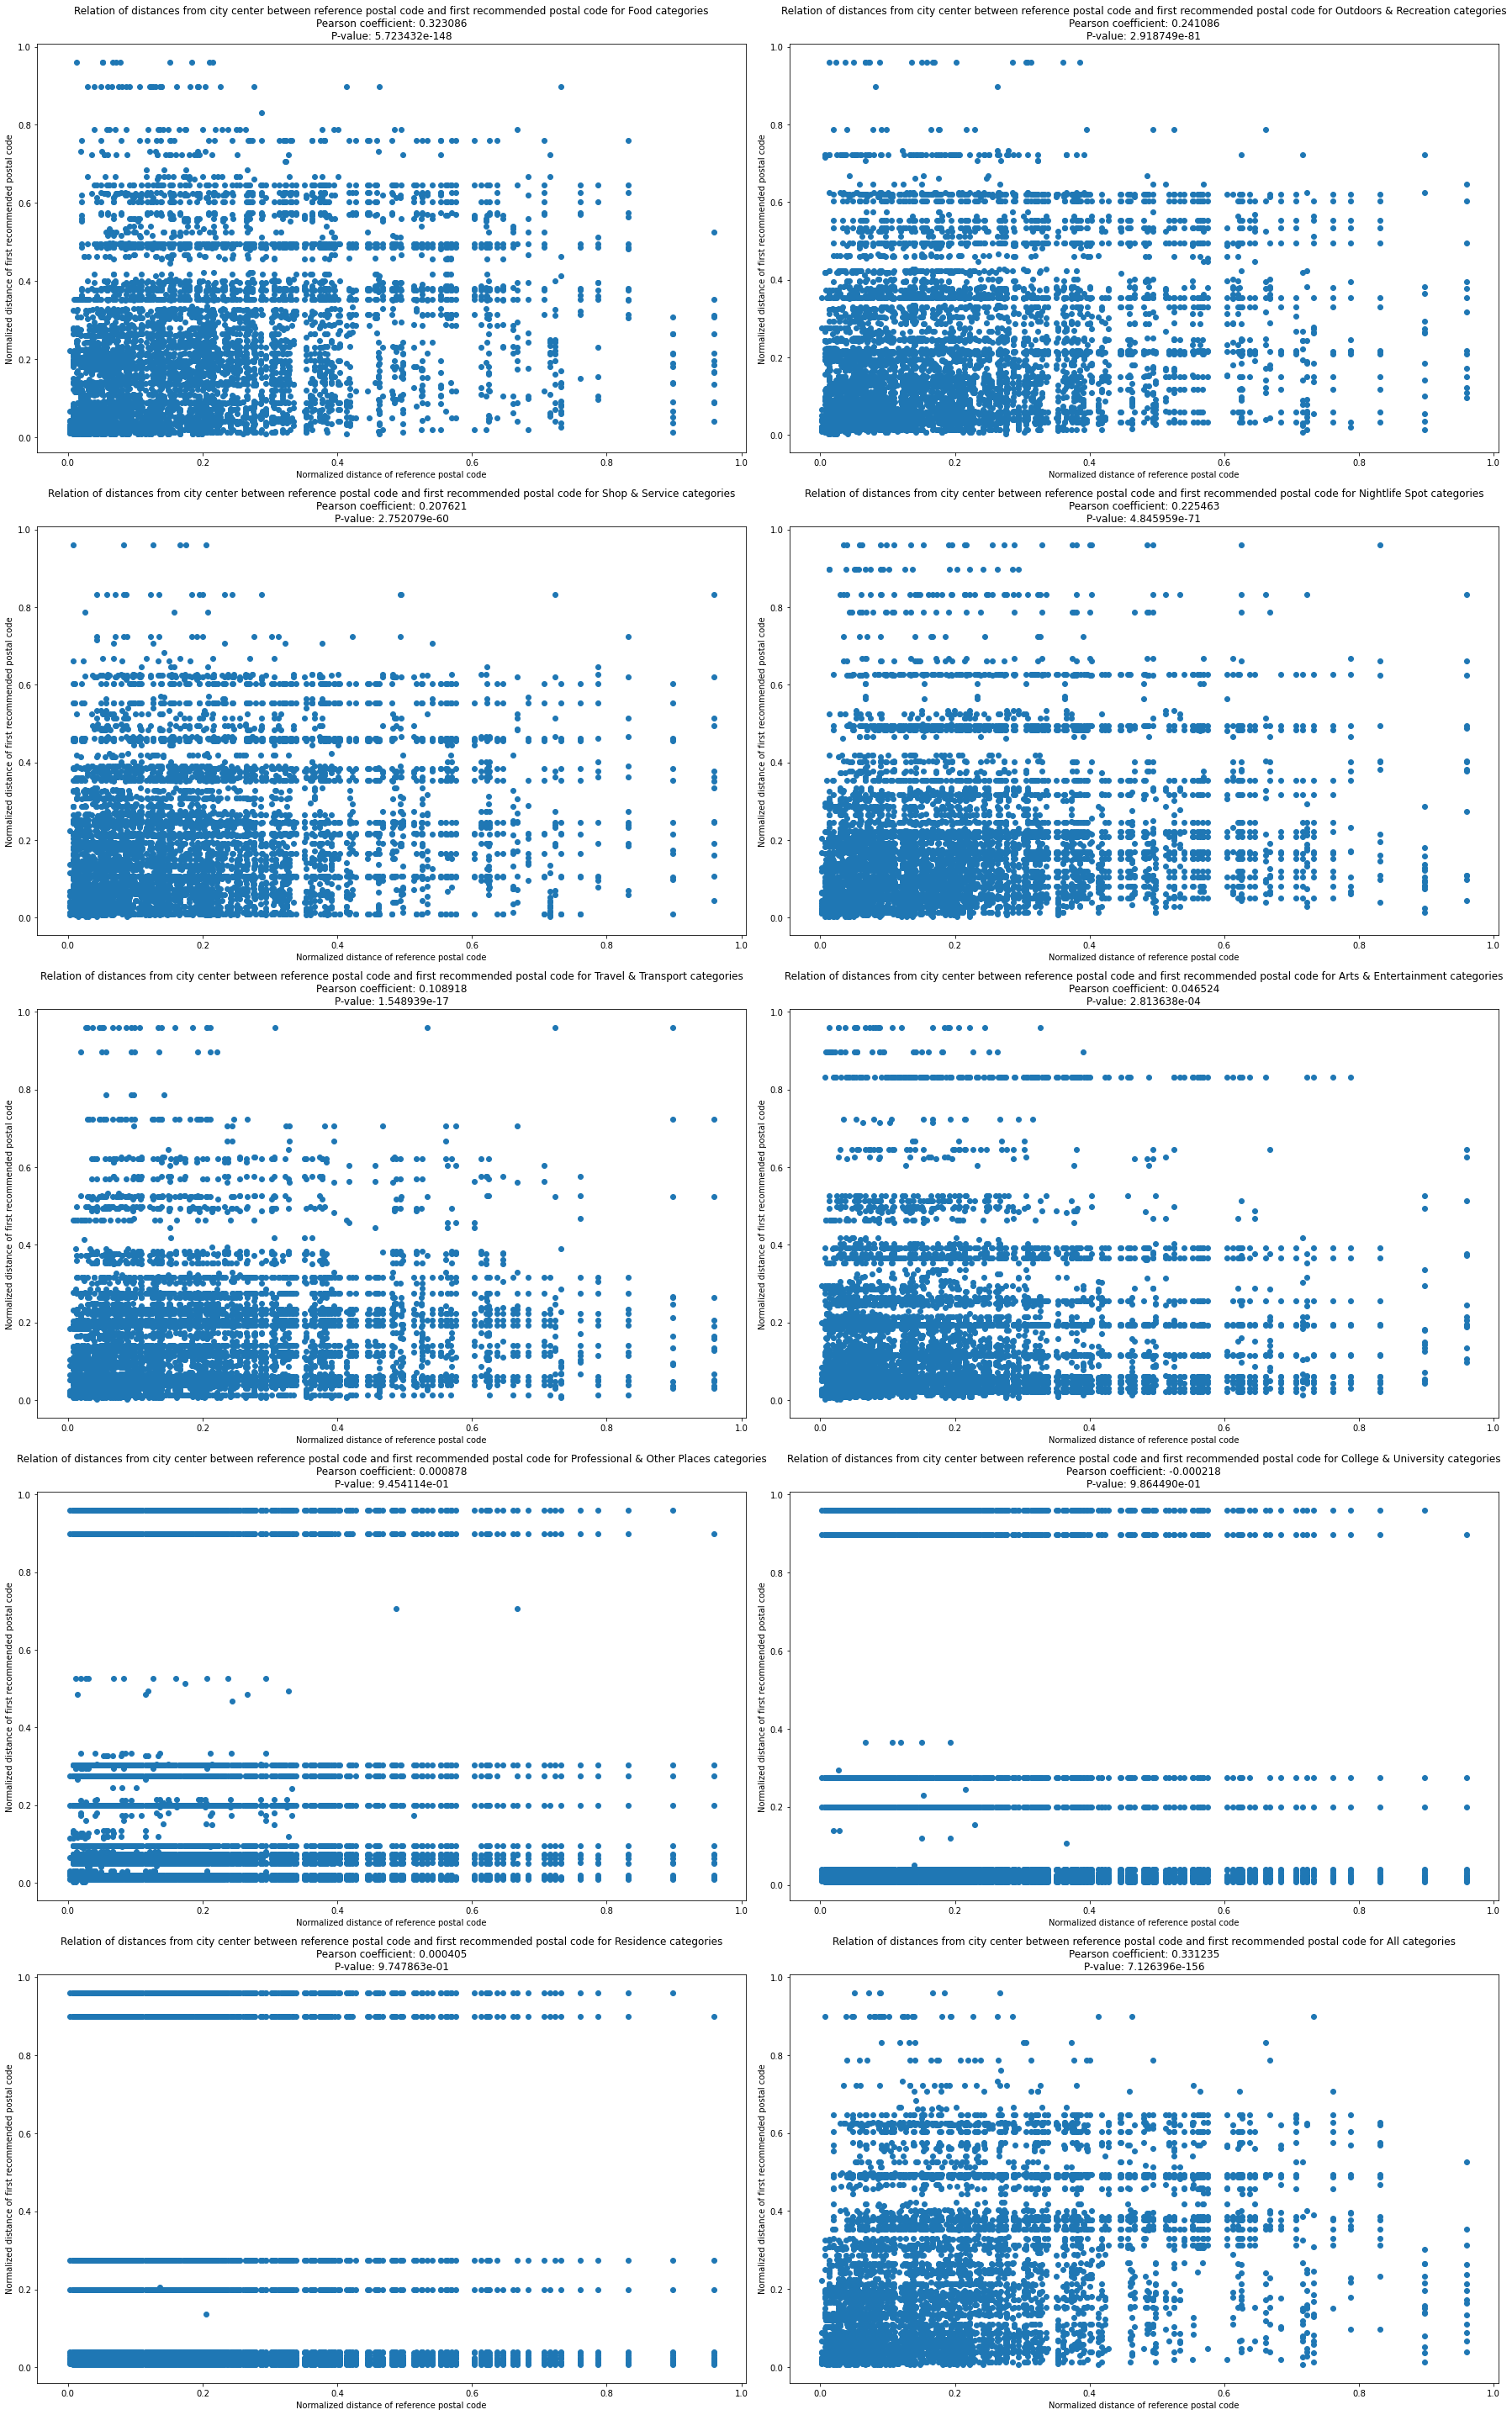

In [776]:
fig, axs = plt.subplots(5,2, figsize=(25, 40))

axs = axs.ravel()
i = 0
for primary_venue_category_to_consider in venues_category_combinations:
    ax = axs[i]
    df_analysis_results_similarity_criterium_to_use = df_analysis_results_similarity_criterium[df_analysis_results_similarity_criterium["primary_venue_category_to_consider"] == primary_venue_category_to_consider] 
    pearson_correlation = pearsonr(
        df_analysis_results_similarity_criterium_to_use['normalized_distance_reference'], 
        df_analysis_results_similarity_criterium_to_use['normalized_distance_first_recommendation'])
    ax.scatter(
        df_analysis_results_similarity_criterium_to_use['normalized_distance_reference'], 
        df_analysis_results_similarity_criterium_to_use['normalized_distance_first_recommendation'])
    ax.set_xlabel('Normalized distance of reference postal code')
    ax.set_ylabel('Normalized distance of first recommended postal code')
    ax.set_title('Relation of distances from city center between reference postal code and first recommended postal code for %s categories\nPearson coefficient: %f\nP-value: %e' %(primary_venue_category_to_consider, pearson_correlation[0], pearson_correlation[1]))
    i += 1 
        
plt.tight_layout()

The scatter plots results show at first to be very disperse, and the pearson correlation values show the following:
- Positive weak correlation between distances when using all categories and food related categories.
- Positive very weak correlation between distances when using nightlife, outdoors, shopping and transport related categories.
- Positive extremely weak correlation between distances when using arts & enterntainment related categories.
- Non existing correlation between distances when using profressional, college and residence categories.

But's it's necessary to remark that the P-value at all cases tend to be extremely close to 0 in all cases with some correlation, denying the null hypothesis.

So it can be considered that there is a weak but significant positive correlation between the distances from the city center of the reference postal code and the most recommended postal code if using food, nightlife, outdoors, shopping, transport and arts & enterntainment related categories, and also using all categories.

For checking the depencency between the most common venue category between the reference postal code and the most recommended postal code, a Chi square test will be built in order to compare both variables.

In [777]:
df_analysis_results_similarity_criterium_to_use = df_analysis_results_similarity_criterium[df_analysis_results_similarity_criterium["primary_venue_category_to_consider"] == "All"] 
contingency_table = pd.crosstab(
    df_analysis_results_similarity_criterium_to_use['most_dense_first_catogory_reference'],
    df_analysis_results_similarity_criterium_to_use['most_dense_first_catogory_first_recommendation'],
    margins = True
)
contingency_table

most_dense_first_catogory_first_recommendation,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,All
most_dense_first_catogory_reference,,,,,,,,
Arts & Entertainment,0,0,28,8,3,1,2,42
College & University,0,0,7,1,2,4,0,14
Food,1,1,2387,434,352,178,91,3444
Nightlife Spot,0,0,429,237,48,38,18,770
Outdoors & Recreation,0,0,458,105,159,56,20,798
Shop & Service,0,0,354,70,89,146,13,672
Travel & Transport,0,2,222,54,26,18,28,350
All,1,3,3885,909,679,441,172,6090


According to the results of the Chi square test, no correlation seems to exist between the most common venue category of the reference postal code and the recommended one. The most common venue category at each recommended postal code is usually a child of Food first category, no matter the most common venue category at the reference postal code. 

This points out to the possibility of Food categories having an excese of influence over the results. In order to check this, an histogram about the type of venues presented in the venues dataset used for working out the densities.

<AxesSubplot:>

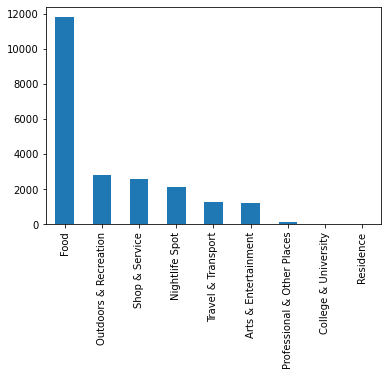

In [780]:
df_spain_venues_filtered['venue_category_primary'].value_counts().plot(kind='bar')

We can see that most of the venues presented are food related. This can explain the big influence that food related venues appears to have over the result, being the most dense venues at either the reference postal codes and the most recommended ones.

On the other hand, there are almost no profressional, college or residence venues. This can explain the uncorrelation of the results regarding distance from the center or most dense venue type when using for the recommendation just venue types of those kinds.

<a id="results-density"></a>
### 4.B. Results for density criterium

For each combination of postal code area available and city available to move in, the recommendation algorithm will be used for getting a series of recommendations based on density, one for each of the venue recommendations lists defined to be considered. For each of these recommendations, the following data will be stored in a dataframe:
- User hypothetical input (city to move in and venue categories to consider).
- Distance and density of each of the postal codes considered given by the recommendation.

In [781]:
analysis_results_density_criterium=[]

for _, city in df_spain_cities.iterrows():
    df_postcodes_to_consider = df_spain_postcodes[df_spain_postcodes["city"] == city["city"]].reset_index(drop=True)
    df_postcodes_density_venues_to_consider = df_spain_postcodes_density_venues[df_spain_postcodes_density_venues.postal_code.isin(df_postcodes_to_consider["postal_code"].values.tolist())].reset_index(drop=True)
    for primary_venue_category_to_consider, venues_to_consider_list in venues_category_combinations.items():
        recommendation_table, density_table = createRecommendatorArray(
            dataframe=df_postcodes_density_venues_to_consider, 
            reference=None, 
            criterium='density', 
            recommendator_enhancer=1/2,
            venues = venues_to_consider_list)
        df_postcodes_to_consider['density'] = density_table
        for _, postcode in df_postcodes_to_consider.iterrows():
            postcode_coordinates = [postcode["postal_code_latitude"], postcode["postal_code_longitude"]]
            city_center_coordinates = [city["latitude"], city["longitude"]]
            distance = get_distance_between_coordinates(postcode_coordinates, city_center_coordinates)
            distance_normalized = distance/city["influence_radius"]
            analysis_results_density_criterium.extend([( 
                postcode['postal_code'],
                distance_normalized, 
                postcode['density'],
                primary_venue_category_to_consider)])

# Convert the postal code list into a pandas dataframe
df_analysis_results_density_criterium = pd.DataFrame([item for item in analysis_results_density_criterium]).reset_index(drop=True)
df_analysis_results_density_criterium.columns = [
              'postal_code', 
              'normalized_distance_to_center', 
              'density', 
              'primary_venue_category_to_consider']
print("Done!                                                                                  \r", end="")


For checking the hypothesis of the correlation between the distances from the city center of every postal code and the density of venues in these postal codes, the following info will be show for each of the venue category lists used previously:
- A scatter plot showing the relationship between distance from center and density for all tests done with these venue category lists to be considered.
- The pearson coefficient and P-value of the relationship between distance from center and density for each of these venue category lists to be considered.

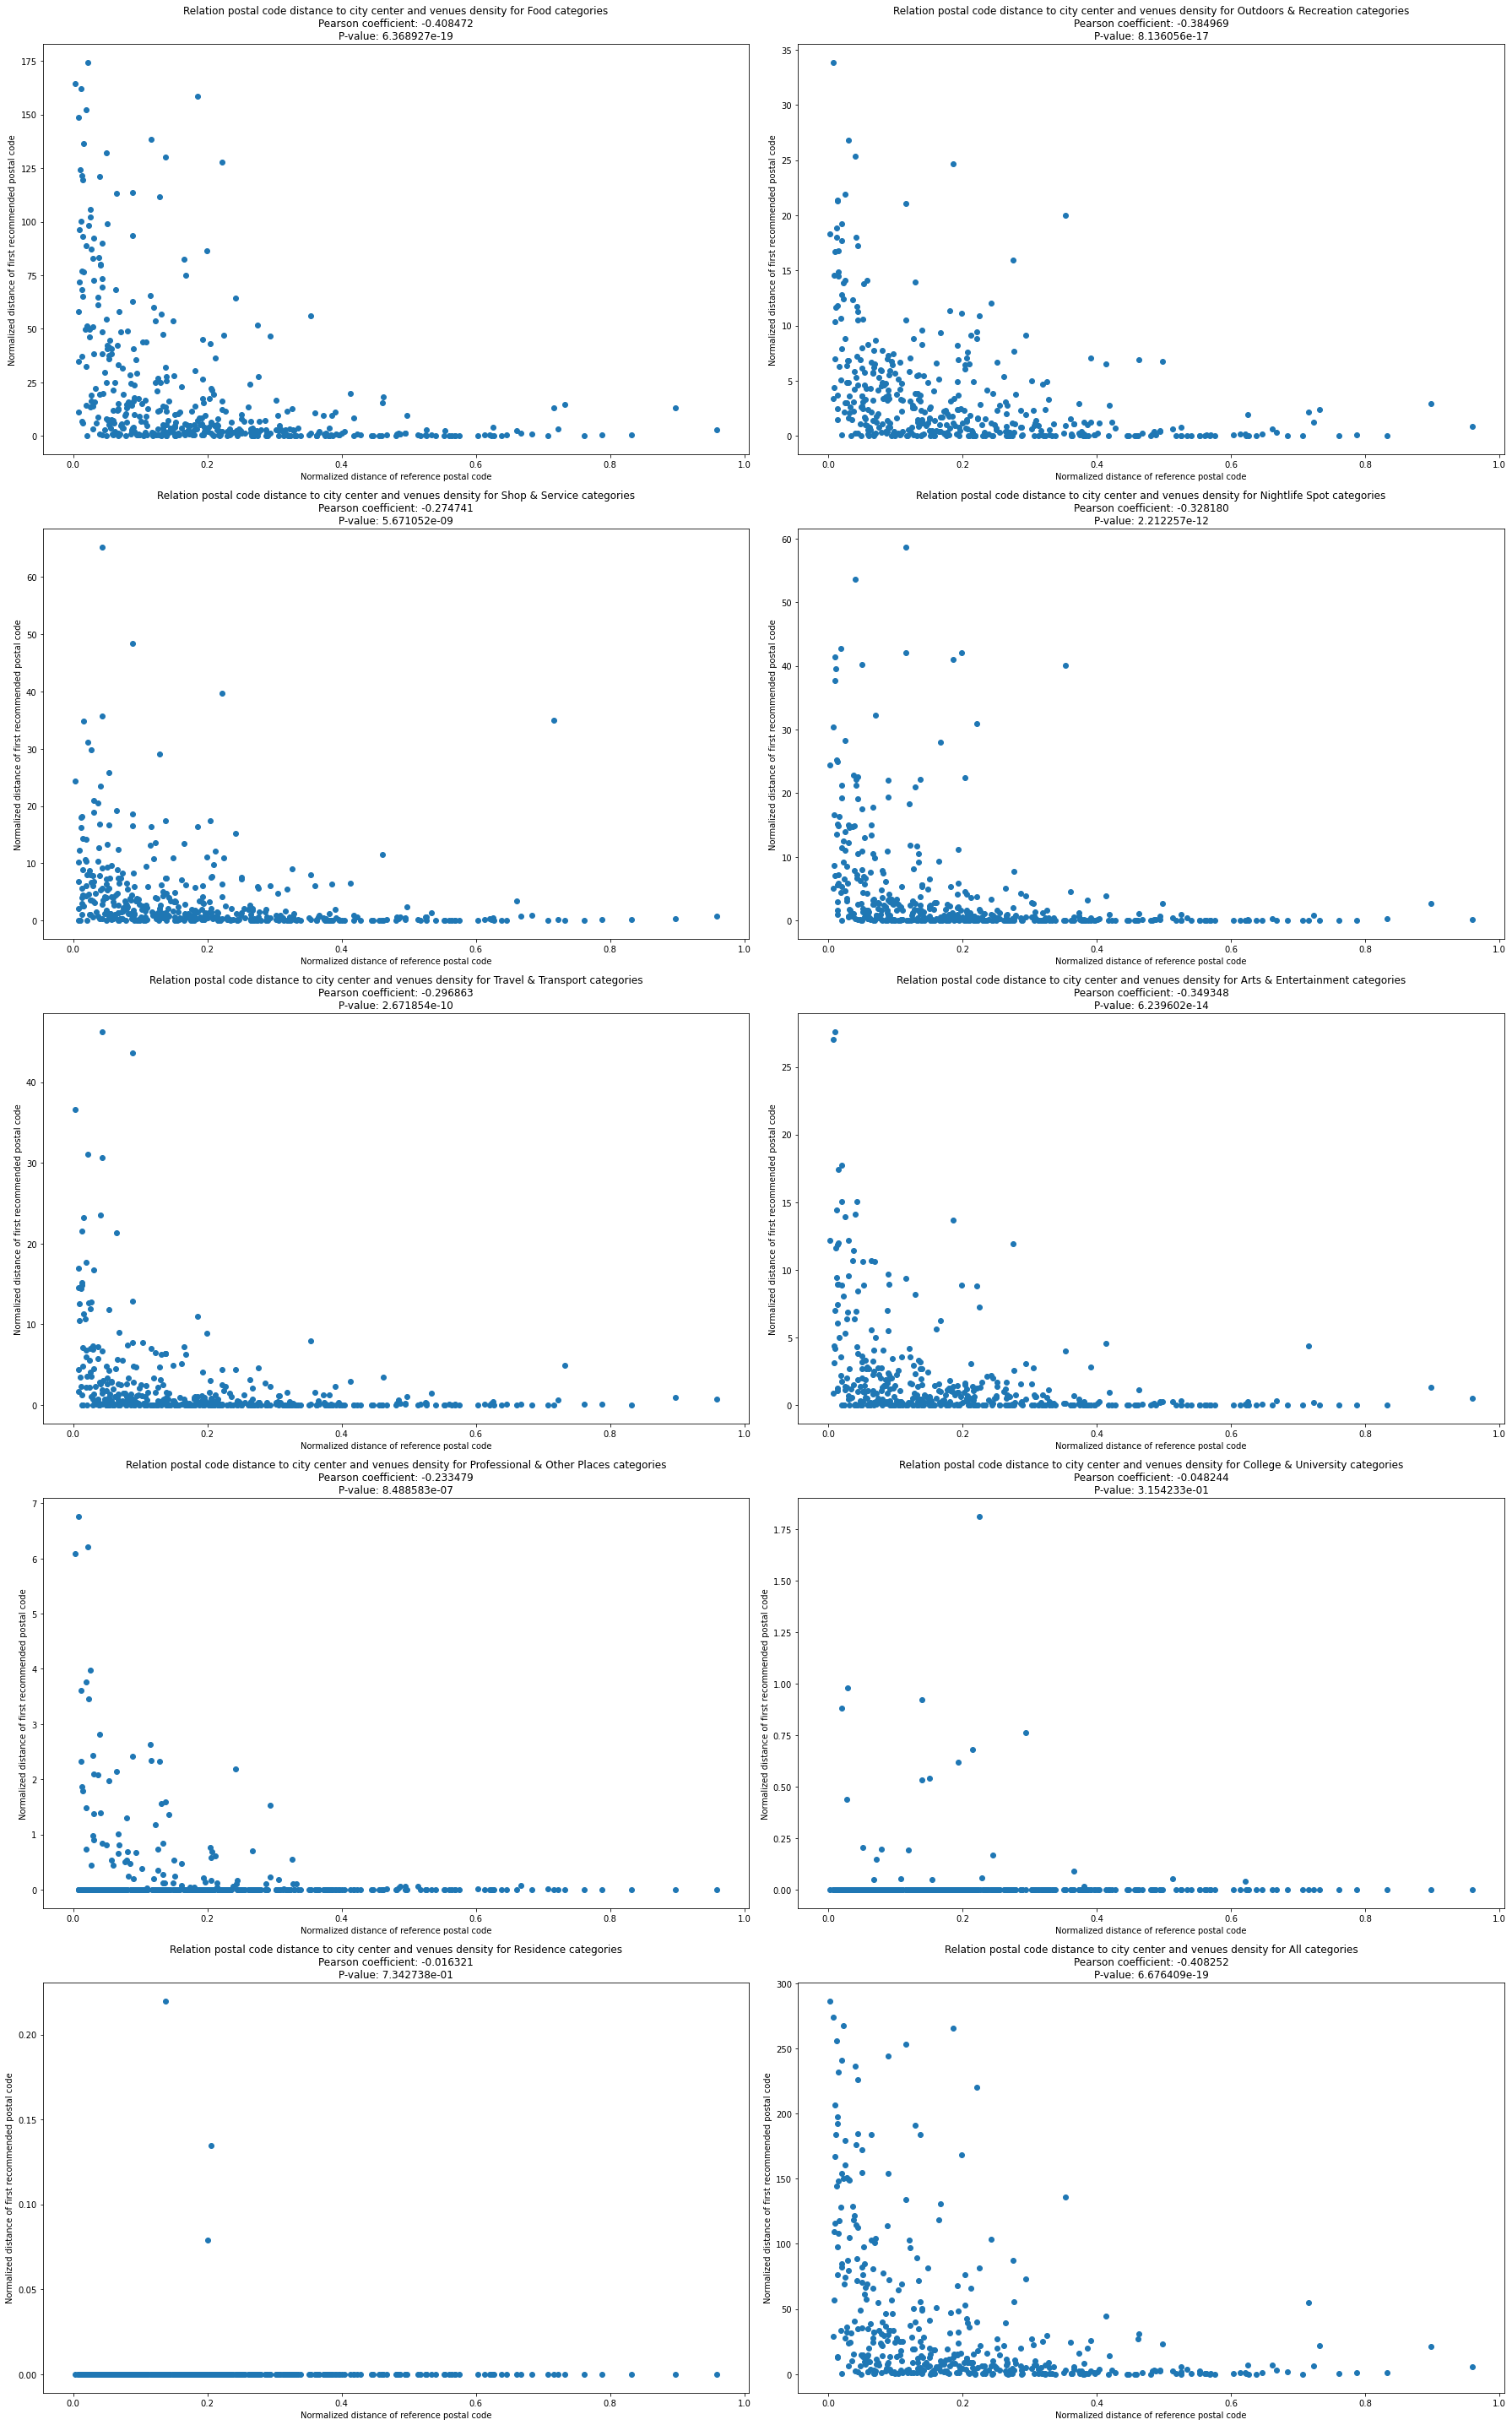

In [784]:
fig, axs = plt.subplots(5,2, figsize=(25, 40))

axs = axs.ravel()
i = 0
for primary_venue_category_to_consider in venues_category_combinations:
    ax = axs[i]
    df_analysis_results_density_criterium_to_use = df_analysis_results_density_criterium[df_analysis_results_density_criterium["primary_venue_category_to_consider"] == primary_venue_category_to_consider] 
    pearson_correlation = pearsonr(
        df_analysis_results_density_criterium_to_use['normalized_distance_to_center'], 
        df_analysis_results_density_criterium_to_use['density'])
    ax.scatter(
        df_analysis_results_density_criterium_to_use['normalized_distance_to_center'], 
        df_analysis_results_density_criterium_to_use['density'])
    ax.set_xlabel('Normalized distance of reference postal code')
    ax.set_ylabel('Normalized distance of first recommended postal code')
    ax.set_title('Relation postal code distance to city center and venues density for %s categories\nPearson coefficient: %f\nP-value: %e' %(primary_venue_category_to_consider, pearson_correlation[0], pearson_correlation[1]))
    i += 1 
        
plt.tight_layout()

Both the scatter plots and the pearson correlation values clearly show the following:
- Negative moderate correlation between distances when using all categories and food related categories.
- Negative weak correlation between distances when using outdoors, nightlife and arts & enterntainment related categories.
- Negative very weak correlation between distances when using profressional, shopping and transport related categories.
- Non existing correlation between distances when using college and residence related categories.

But's it's necessary to remark that the P-value at all cases tend to be extremely close to 0 in all cases with some correlation, denying the null hypothesis.

So it can be considered that there is in general terms a weak but significant negative correlation between the distances from the city center of the reference postal code and the most recommended postal code if using food, outdoors, nightlife, arts & enterntainment, profressional, shopping and transport, and also using all categories.

The histogram of venue types present in the venues filtered dataset previously shown previously explain both the influence of food categories over the result using all categories and the lack of correlation between distance from center and density of venues when using college and residence categories.

<a id="discussion"></a>
## 5. Discussion

After the statistical analysis done in the results section, the following hypothesis has been confirmed when using similarity criterium:
- There is a general positive weak correlation between the distance from city center of the reference postal code and the most recommended one. This correlation is inexistent only in the situations where profressional, college and residence related venues categories are used for the recommendation.
- There is not a correlation between the most dense venue category types in the reference postal conde and the most common venue category types in the recommended postal code. In both cases food related categories are the most common ones. 
- Food related categories are the venue categories which has the most influence over the recommendations done, because of the dominance of these categories in the data used for creating the recommendation algorithm.

And the following hypothesis has been confirmed when using density criterium:
- There is a general negative moderate to weak correlation between the distance from city center of each postal code and the density of venues provided by the recommendation algorithm. This correlation is inexistent only in the situations where college and residence related categories are used for the recommendation.
- Food related categories are the venue categories with the most influence over the density observed in the postal code areas, because of the dominance of these categories in the data used for creating the recommendation algorithm.

Based on these hypothesis confirmed, the content-based recommendation system can be considered as valid for providing recommendations of postal codes where to live based on the preference of the user about venue types he is interested in, cities where the user wants to move in and postal code areas which the user lives now or considers them as fitting well with him.

Nonetheless, it has been observed that the venues related with food (like supermarkets and restaurants) have an excesive influence over the recommendation done, whatever recommendation criterium is chosen. In order to limit the influence of these kind of venues, the following points are proposed as next steps to follow:
- Increment the number of venues obtained in the data obtention section by exploring the use of other databases and APIs. A possibility to be considered is the substitution of the use of Foursquare API by the use of Google Places API, which may be more complete and can provide more and more varied venues.
- It's important to notice that those venues more common in the data obtained, like food, shop and nightlive related venues, tend to be smaller than those venues which are less common in the data obtained, like colleges, residences, parks and professional places. If accurate, or at least aproximate, info can be obtained about the size occupied in square meters by each venue (or at least the average size of each venue type), this information can be introduced in the postal codes venues density dataset. This dataset can be based on surface occupied by venues of each type instead of number of venues of each type.

Other next steps to follow in order to improve the recommendation system are the following:
- Include other information not related with venues in order to use it for making the recommendations. This information can be about the demographical statistics of each area, the type of houses in each area or the cost of living in each area.
- Use smaller areas for the recommendations, like for example census sections, which are smaller than postal code areas.
- Provide additional info about each area recommended, like for instance a list of houses available to rent in the most recommended area.
- Add more cities to the recommendation system, either from Spain or abroad.


<a id="conclusions"></a>
## 6. Conclusions

Up to this point the work done has been the following:
- Data about 15 most populous cities in Spain, postal code areas located in these cities and venues located at these postal code areas has been obtained and processed in order to take the density of each venue category at every postal code area processed.
- The processed data has been used for creating and tuning a content-based recommendation algorithm for getting recommended postal code areas in a target city to move in based on the following:
    - Wether the user prefers to use a recommendation criterium based on similarity with another postal code or based on the density of venues.
    - If similarity criterium chosen, the postal code area to be taken as reference.
    - The target city to move in.
    - The venue categories the user is interested in.
- A visualization tool has been created in the form of functions for using the recommendation algorithm with the target of showing a cloropeth map of the target city with the postal codes of that city coloured depending on the recommendation mark given to each of them.
- An application has been created for using the recommendation algorithm and the visualization tools, providing an easy-to-use user interface for getting a recommendation.
- A series of hypothesis has been exposed after an exploratory analysis done with the application, and a series of statistical tools has been used in order to confirm them or denying them.
- The statistical results have been used in order to confirm the hypothesis exposed after the exploratory analysis.
- Based on the exploratory analysis, the hypothesis confirmed and improvement ideas, a series of steps has been proposed to be followed as a work for improving the recommendation system.
